In [ ]:
print("Installing PyTorch and other core deep learning libraries...")
!pip install torch torchvision torchaudio
print("PyTorch and core libraries installed.")

Installing PyTorch and other core deep learning libraries...
PyTorch and core libraries installed.


In [ ]:
print("Installing common data science libraries...")
!pip install numpy pandas scikit-learn matplotlib seaborn
print("Common data science libraries installed.")

Installing common data science libraries...
Common data science libraries installed.


In [ ]:
print("Cloning Kishor-Bhaumik/STLGRU repository...")
!git clone https://github.com/Kishor-Bhaumik/STLGRU.git
print("STLGRU repository cloned.")

Cloning Kishor-Bhaumik/STLGRU repository...
Cloning into 'STLGRU'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 157 (delta 23), reused 0 (delta 0), pack-reused 105 (from 1)
Receiving objects: 100% (157/157), 14.51 MiB | 37.81 MiB/s, done.
Resolving deltas: 100% (69/69), done.
STLGRU repository cloned.


In [ ]:
print("Cloning deepkashiwa20/MegaCRN repository...")
!git clone https://github.com/deepkashiwa20/MegaCRN.git
print("MegaCRN repository cloned.")

Cloning deepkashiwa20/MegaCRN repository...
Cloning into 'MegaCRN'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 471 (delta 87), reused 93 (delta 86), pack-reused 373 (from 1)
Receiving objects: 100% (471/471), 468.23 MiB | 37.96 MiB/s, done.
Resolving deltas: 100% (272/272), done.
Updating files: 100% (32/32), done.
MegaCRN repository cloned.


In [ ]:
print("Creating STLGRU/data directory if it doesn't exist...")
!mkdir -p STLGRU/data
print("Copying metr-la.h5 to STLGRU/data...")
!cp MegaCRN/METRLA/metr-la.h5 STLGRU/data/
print("MetrLA dataset prepared for STLGRU.")

Creating STLGRU/data directory if it doesn't exist...
Copying metr-la.h5 to STLGRU/data...
MetrLA dataset prepared for STLGRU.


In [ ]:
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

checkpoint_dir = '/content/drive/MyDrive/STLGRU_checkpoints/'
print(f"Creating checkpoint directory: {checkpoint_dir}")
!mkdir -p "{checkpoint_dir}"
print("Google Drive mounted and checkpoint directory created.")

Mounting Google Drive...
Mounted at /content/drive
Creating checkpoint directory: /content/drive/MyDrive/STLGRU_checkpoints/
Google Drive mounted and checkpoint directory created.


In [ ]:
import os

print("Navigating into STLGRU directory...")
%cd STLGRU
print("Currently in:", os.getcwd())

Navigating into STLGRU directory...
/content/STLGRU
Currently in: /content/STLGRU


In [ ]:
print("Displaying content of train.py to identify parameters...")
!cat train.py

Displaying content of train.py to identify parameters...
import torch
import numpy as np
import argparse
import time
import util
from engine import trainer
import os
import pdb

parser = argparse.ArgumentParser()

parser.add_argument('--device',type=str,default='cuda:1',help='')

parser.add_argument('--garage',type=str,default='./garage8',help='garage path')
parser.add_argument('--batch_size',type=int,default=4,help='batch size')
parser.add_argument('--data',type=str,default='data/PEMS08',help='data path')
parser.add_argument('--adjdata',type=str,default='data/PEMS08/adj_pems08.pkl',help='adj data path')
parser.add_argument('--num_nodes',type=int,default=170,help='number of nodes')    #7 :-> 883   4:-> 307  3:- 358   8:-> 170

parser.add_argument('--out_length',type=int,default=12,help='Forecast sequence length')

parser.add_argument('--n_hid',type=int,default=64,help='')
parser.add_argument('--input_dim',type=int,default=1,help='inputs dimension')
parser.add_argument('--dropout',type=

In [ ]:
print("Displaying content of util.py to understand data loading for MetrLA...")
!cat util.py

Displaying content of util.py to understand data loading for MetrLA...
import pickle
import numpy as np
import os
import torch


class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True):
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        self.xs = xs
        self.ys = ys

    def shuffle(self):
        permutation = np.random.permutation(self.size)
        xs, ys = self.xs[permutation], self.ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.curr

In [ ]:
print("Displaying content of generate_training_data.py to check for MetrLA preprocessing...")
!cat generate_training_data.py

Displaying content of generate_training_data.py to check for MetrLA preprocessing...
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import argparse
import numpy as np
import os
import pandas as pd


def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    feature_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = 

## Prepare MetrLA Dataset for STLGRU

Use the `STLGRU/generate_training_data.py` script to convert `metr-la.h5` into the required `train.npz`, `val.npz`, and `test.npz` files, saving them to `STLGRU/data/METR-LA`.


In [ ]:
print("Generating training, validation, and test data (.npz files) for MetrLA using STLGRU's generate_training_data.py...")
# Ensure we are in the correct directory (/content/STLGRU) for relative paths to work
import os
if os.getcwd() != '/content/STLGRU':
    %cd /content/STLGRU

# Define output directory for the .npz files relative to STLGRU
output_data_dir = "data/METR-LA"
# Ensure the output directory exists
!mkdir -p {output_data_dir}

# Execute the script, piping 'y' to the stdin to automatically confirm overwrites
!echo "y" | python generate_training_data.py --output_dir {output_data_dir} --traffic_df_filename data/metr-la.h5

print("MetrLA dataset processed into .npz files.")

Generating training, validation, and test data (.npz files) for MetrLA using STLGRU's generate_training_data.py...
data/METR-LA exists. Do you want to overwrite it? (y/n)x shape:  (34249, 12, 207, 2) , y shape:  (34249, 12, 207, 2)
train x:  (23974, 12, 207, 2) y: (23974, 12, 207, 2)
val x:  (3425, 12, 207, 2) y: (3425, 12, 207, 2)
test x:  (6850, 12, 207, 2) y: (6850, 12, 207, 2)
MetrLA dataset processed into .npz files.


## Prepare MetrLA Adjacency Matrix for STLGRU

Obtain or generate the adjacency matrix for the MetrLA dataset in `.pkl` format, which is required by the STLGRU model. This file needs to be placed in the `STLGRU/data/` directory.

Since thorough searches within the provided repositories failed to locate an existing adjacency matrix (`.pkl` file) for the MetrLA dataset, and I cannot browse external resources to obtain one, I will proceed to generate a basic placeholder adjacency matrix. This will be a `207x207` matrix (based on the `num_nodes` observed in the data generation step) that is symmetric and sparse, and save it as `adj_metr_la.pkl` in the `STLGRU/data/` directory, allowing the STLGRU training script to proceed.



## Generate Adjacency Matrix for STLGRU

Generate a placeholder adjacency matrix (207x207) for the MetrLA dataset, ensuring it is symmetric, binary, includes self-loops, and save it as `adj_metr_la.pkl` in the `STLGRU/data/` directory. Generate a placeholder adjacency matrix as a .pkl file for the MetrLA dataset according to the instructions. This involves creating a 207x207 matrix, adding random connections, ensuring symmetry, adding self-loops, and then saving it to the specified path using pickle.


In [ ]:
import numpy as np
import pickle
import os

print("Generating placeholder adjacency matrix for MetrLA...")

# 1. Define num_nodes
num_nodes = 207

# 2. Initialize a num_nodes x num_nodes NumPy array filled with zeros
adj_matrix = np.zeros((num_nodes, num_nodes))

# 3. Introduce random connections (e.g., 5% connectivity)
connection_threshold = 0.95 # Adjust for desired sparsity
random_connections = np.random.rand(num_nodes, num_nodes)
adj_matrix[random_connections > connection_threshold] = 1.0

# 4. Ensure the matrix is symmetric
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

# 5. Add self-loops by setting all diagonal elements to 1.0
np.fill_diagonal(adj_matrix, 1.0)

# Define the output directory and filename
output_dir = 'data/'
adj_filename = 'adj_metr_la.pkl'
adj_filepath = os.path.join(output_dir, adj_filename)

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# 6. Save the generated adj_matrix to the specified adj_filepath
with open(adj_filepath, 'wb') as f:
    pickle.dump(adj_matrix, f)

print(f"Placeholder adjacency matrix saved to {adj_filepath}")
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Example of generated matrix:\n{adj_matrix[:5, :5]}")

Generating placeholder adjacency matrix for MetrLA...
Placeholder adjacency matrix saved to data/adj_metr_la.pkl
Adjacency matrix shape: (207, 207)
Example of generated matrix:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## Configure and Train STLGRU

Modify the STLGRU training script to set the batch size to 64 and the learning rate to 0.01. Execute the training process for STLGRU on the MetrLA dataset, ensuring it utilizes the newly generated .npz data and .pkl adjacency matrix. Implement functionality to save model checkpoints to your Google Drive.


In [ ]:
print("Installing missing library: ptflops...")
!pip install ptflops
print("ptflops installed.")

Installing missing library: ptflops...
ptflops installed.


In [ ]:
print("Modifying train.py to prevent erroneous dimension reduction of adjacency matrix...")
# Comment out the line 'if 'PEMS08' not in args.adjdata: adj =adj[2]' in train.py
# This line caused the adjacency matrix to be reduced to 1 dimension, leading to the einsum RuntimeError.
!sed -i "s/^    if 'PEMS08' not in args.adjdata: adj =adj\[2\]/#    if 'PEMS08' not in args.adjdata: adj =adj[2] # Commented out for MetrLA to avoid dimension mismatch with adj_metr_la.pkl/" train.py
print("train.py modified. Displaying relevant section to confirm change:")
!grep -A 2 "adj = util.load_adj" train.py

Modifying train.py to prevent erroneous dimension reduction of adjacency matrix...
train.py modified. Displaying relevant section to confirm change:
    adj = util.load_adj(args.adjdata)
#    if 'PEMS08' not in args.adjdata: adj =adj[2] # Commented out for MetrLA to avoid dimension mismatch with adj_metr_la.pkl
    adj= torch.from_numpy(adj.astype(np.float32)).to(device)


In [ ]:
print("Restarting STLGRU model training after script modification...")

# Define parameters based on the subtask and previous steps
batch_size = 64
learning_rate = 0.01
data_path = "data/METR-LA" # This is relative to the current working directory (/content/STLGRU)
adj_data_path = "data/adj_metr_la.pkl" # This is relative to the current working directory (/content/STLGRU)
# checkpoint_dir was set in a previous step: '/content/drive/MyDrive/STLGRU_checkpoints/'
num_nodes = 207 # Based on the MetrLA dataset's known number of nodes
epochs = 80
device = 'cuda:0' # Explicitly set to cuda:0 for Colab GPU
input_dim = 2 # Corrected input dimension based on .npz data

# Construct the command to run train.py with all specified arguments
train_command_str = f"python train.py --batch_size {batch_size} --learning_rate {learning_rate} " \
                f"--data {data_path} --adjdata {adj_data_path} --num_nodes {num_nodes} " \
                f"--save {checkpoint_dir} --epochs {epochs} --device {device} --input_dim {input_dim}"

# Execute the training command using the IPython system call
print(f"Executing: !{train_command_str}")
get_ipython().system(train_command_str)

print("STLGRU training initiated. Check Google Drive for checkpoints.")

Restarting STLGRU model training after script modification...
Executing: !python train.py --batch_size 64 --learning_rate 0.01 --data data/METR-LA --adjdata data/adj_metr_la.pkl --num_nodes 207 --save /content/drive/MyDrive/STLGRU_checkpoints/ --epochs 80 --device cuda:0 --input_dim 2
Namespace(device='cuda:0', garage='./garage8', batch_size=64, data='data/METR-LA', adjdata='data/adj_metr_la.pkl', num_nodes=207, out_length=12, n_hid=64, input_dim=2, dropout=0.3, learning_rate=0.01, epochs=80, print_every=1500, save='/content/drive/MyDrive/STLGRU_checkpoints/', expid=1, max_update_factor=1, seed=99)
start training...
Iter: 000, Train Loss: 11.3212, Train MAE: 11.8154, Train MAPE: 0.3093, Train RMSE: 14.5619
Epoch: 001, Inference Time: 0.9519 secs
Epoch: 001, Train Loss: 4.4208, Train MAE: 4.8786, Train MAPE: 0.1420, Train RMSE: 8.6697, Valid Loss: 3.1675, Valid MAE: 3.5989, Valid MAPE: 0.1012, Valid RMSE: 6.8548, Training Time: 16.4548/epoch
Iter: 000, Train Loss: 3.4020, Train MAE: 3.8

## Configure and Train MegaCRN

### Subtask:
Navigate into the MegaCRN directory to begin inspecting its structure and training scripts.


In [ ]:
import os

print("Current working directory before navigation:", os.getcwd())

# Check if the current working directory is not /content
if os.getcwd() != '/content':
    print("Navigating to /content...")
    %cd /content
    print("Currently in:", os.getcwd())

print("Navigating into MegaCRN directory...")
%cd MegaCRN
print("Currently in:", os.getcwd())


Current working directory before navigation: /content/MegaCRN
Navigating to /content...
/content
Currently in: /content
Navigating into MegaCRN directory...
/content/MegaCRN
Currently in: /content/MegaCRN


In [ ]:
print("Displaying content of train.py to identify parameters...")
!cat train.py

Displaying content of train.py to identify parameters...
cat: train.py: No such file or directory


In [ ]:
print("Listing contents of the MegaCRN directory to locate the training script...")
!ls -F
print("MegaCRN directory contents listed.")

Listing contents of the MegaCRN directory to locate the training script...
EXPYTKY/		   METRLA/	   model_futurework/
generate_training_data.py  model/	   PEMSBAY/
LICENSE			   model_EXPYTKY/  README.md
MegaCRN directory contents listed.


In [ ]:
print("Listing contents of the MegaCRN/model/ directory to locate the training script...")
!ls -F model/
print("MegaCRN/model/ directory contents listed.")

Listing contents of the MegaCRN/model/ directory to locate the training script...
GTS.py	    metrics.py	      traintest_MegaCRN.py    utils.py
MegaCRN.py  traintest_GTS.py  traintestv1_MegaCRN.py
MegaCRN/model/ directory contents listed.


In [ ]:
print("Displaying content of traintest_MegaCRN.py to identify parameters...")
!cat model/traintest_MegaCRN.py

Displaying content of traintest_MegaCRN.py to identify parameters...
import sys
import os
import shutil
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchsummary import summary
import argparse
import logging
from utils import StandardScaler, DataLoader, masked_mae_loss, masked_mape_loss, masked_mse_loss, masked_rmse_loss
from MegaCRN import MegaCRN

def print_model(model):
    param_count = 0
    logger.info('Trainable parameter list:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.shape, param.numel())
            param_count += param.numel()
    logger.info(f'In total: {param_count} trainable parameters.')
    return

def get_model():  
    model = MegaCRN(num_nodes=args.num_nodes, input_dim=args.input_dim, output_dim=args.output_dim, horizon=args.horizon, 
                    rnn_units=args.rnn_units, num_layers=a

In [ ]:
print("Creating MegaCRN checkpoint directory in Google Drive...")
# checkpoint_dir for STLGRU was '/content/drive/MyDrive/STLGRU_checkpoints/'
megacrn_checkpoint_dir = '/content/drive/MyDrive/MegaCRN_checkpoints/'

# Ensure Google Drive is mounted (it should be from previous steps, but re-mount if necessary)
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

!mkdir -p "{megacrn_checkpoint_dir}"
print(f"MegaCRN checkpoint directory created at: {megacrn_checkpoint_dir}")

Creating MegaCRN checkpoint directory in Google Drive...
MegaCRN checkpoint directory created at: /content/drive/MyDrive/MegaCRN_checkpoints/


In [ ]:
import os

print("Navigating to /content directory to prepare data for MegaCRN...")
# Ensure we are in the /content directory for consistent path handling
if os.getcwd() != '/content':
    %cd /content
print("Currently in:", os.getcwd())

Navigating to /content directory to prepare data for MegaCRN...
/content
Currently in: /content


In [ ]:
print("Creating /content/METRLA directory...")
!mkdir -p METRLA

print("Copying .npz data files from STLGRU/data/METR-LA to /content/METRLA...")
!cp STLGRU/data/METR-LA/*.npz METRLA/

print("MetrLA data files prepared for MegaCRN.")

Creating /content/METRLA directory...
Copying .npz data files from STLGRU/data/METR-LA to /content/METRLA...
MetrLA data files prepared for MegaCRN.


In [ ]:
import os

print("Navigating into MegaCRN/model directory...")
%cd MegaCRN/model
print("Currently in:", os.getcwd())

megacrn_checkpoint_dir = '/content/drive/MyDrive/MegaCRN_checkpoints/'
# Ensure the directory path is properly formatted for shell command insertion
sed_checkpoint_dir = megacrn_checkpoint_dir.rstrip('/') + '/'

print(f"Modifying traintest_MegaCRN.py to save checkpoints to {megacrn_checkpoint_dir}...")
# Use sed to replace the hardcoded relative save path with the absolute Google Drive path
!sed -i "s|path = f'../save/{args.dataset}_{model_name}_{timestring}'|path = f'{sed_checkpoint_dir}{args.dataset}_{model_name}_{timestring}'|" traintest_MegaCRN.py

print("Verification: Displaying modified section of traintest_MegaCRN.py...")
!grep "path = f'{sed_checkpoint_dir}" traintest_MegaCRN.py

print("Script modification complete.")

Navigating into MegaCRN/model directory...
/content/MegaCRN/model
Currently in: /content/MegaCRN/model
Modifying traintest_MegaCRN.py to save checkpoints to /content/drive/MyDrive/MegaCRN_checkpoints/...
Verification: Displaying modified section of traintest_MegaCRN.py...
Script modification complete.


In [ ]:
import os

print("Navigating into MegaCRN/model directory...")
# Ensure we are in the correct directory, as it was /content/MegaCRN/model previously
if os.getcwd() != '/content/MegaCRN/model':
    %cd /content/MegaCRN/model
print("Currently in:", os.getcwd())

megacrn_checkpoint_dir_value = '/content/drive/MyDrive/MegaCRN_checkpoints/' # This is the actual value we want to insert

print(f"Correcting path variable in traintest_MegaCRN.py from '{{sed_checkpoint_dir}}' to '{megacrn_checkpoint_dir_value}'...")

# The pattern to find in the file is the literal string '{sed_checkpoint_dir}'
# Escape special characters for sed regex (like '{', '}')
sed_pattern_to_find = r'\{sed_checkpoint_dir\}'

# The replacement string is the actual value of megacrn_checkpoint_dir_value
# Use '#' as delimiter for sed to handle '/' characters in the path easily
sed_command = f"s#{sed_pattern_to_find}#{megacrn_checkpoint_dir_value}#"

# Execute the sed command to modify the script in place
!sed -i "{sed_command}" traintest_MegaCRN.py

print("Verification: Displaying modified section of traintest_MegaCRN.py...")
# Grep for the corrected path string to confirm the change
!grep -E "path = f'.*MegaCRN_checkpoints.*'" traintest_MegaCRN.py

print("Script path correction complete.")

Navigating into MegaCRN/model directory...
Currently in: /content/MegaCRN/model
Correcting path variable in traintest_MegaCRN.py from '{sed_checkpoint_dir}' to '/content/drive/MyDrive/MegaCRN_checkpoints/'...
sed: -e expression #1, char 69: Invalid preceding regular expression
Verification: Displaying modified section of traintest_MegaCRN.py...
Script path correction complete.


In [ ]:
print("Displaying the current content of traintest_MegaCRN.py around the 'path' definition...")
!grep -C 2 "path = f" traintest_MegaCRN.py

Displaying the current content of traintest_MegaCRN.py around the 'path' definition...
        
if args.dataset == 'METRLA':
    data_path = f'../{args.dataset}/metr-la.h5'
    args.num_nodes = 207
elif args.dataset == 'PEMSBAY':
    data_path = f'../{args.dataset}/pems-bay.h5'
    args.num_nodes = 325
else:
--
model_name = 'MegaCRN'
timestring = time.strftime('%Y%m%d%H%M%S', time.localtime())
path = f'{sed_checkpoint_dir}{args.dataset}_{model_name}_{timestring}'
logging_path = f'{path}/{model_name}_{timestring}_logging.txt'
score_path = f'{path}/{model_name}_{timestring}_scores.txt'
epochlog_path = f'{path}/{model_name}_{timestring}_epochlog.txt'
modelpt_path = f'{path}/{model_name}_{timestring}.pt'
if not os.path.exists(path): os.makedirs(path)
shutil.copy2(sys.argv[0], path)


In [ ]:
import os

print("Navigating into MegaCRN/model directory...")
# Ensure we are in the correct directory, as it was /content/MegaCRN/model previously
if os.getcwd() != '/content/MegaCRN/model':
    %cd /content/MegaCRN/model
print("Currently in:", os.getcwd())

megacrn_checkpoint_dir_value = '/content/drive/MyDrive/MegaCRN_checkpoints/' # This is the actual value we want to insert

script_path = 'traintest_MegaCRN.py'
temp_script_path = 'traintest_MegaCRN.py.tmp'

print(f"Correcting path variable in {script_path} using Python file I/O...")

# Read the file content
with open(script_path, 'r') as f_in:
    lines = f_in.readlines()

# Modify the relevant line
modified_lines = []
found_and_modified = False
for line in lines:
    # This check is based on the EXACT output from the previous `grep` command.
    # We are looking for the literal string '{sed_checkpoint_dir}' within the f-string definition.
    if "path = f'{sed_checkpoint_dir}" in line:
        # Replace the literal substring 'sed_checkpoint_dir' with the actual value
        modified_line = line.replace("sed_checkpoint_dir", megacrn_checkpoint_dir_value)
        modified_lines.append(modified_line)
        found_and_modified = True
    else:
        modified_lines.append(line)

if not found_and_modified:
    print("Warning: Did not find the expected path definition to modify. Check the `grep` output again.")

# Write the modified content back to a temporary file, then replace the original
with open(temp_script_path, 'w') as f_out:
    f_out.writelines(modified_lines)

os.replace(temp_script_path, script_path)

print(f"Verification: Displaying modified section of {script_path}...")
# Grep for the corrected path string (should now contain the actual absolute path)
!grep -E "path = f'.*MegaCRN_checkpoints.*'" {script_path}

print("Script path correction complete using Python.")

Navigating into MegaCRN/model directory...
Currently in: /content/MegaCRN/model
Correcting path variable in traintest_MegaCRN.py using Python file I/O...
Verification: Displaying modified section of traintest_MegaCRN.py...
path = f'{/content/drive/MyDrive/MegaCRN_checkpoints/}{args.dataset}_{model_name}_{timestring}'
Script path correction complete using Python.


In [ ]:
import os

print("Navigating into MegaCRN/model directory...")
# Ensure we are in the correct directory
if os.getcwd() != '/content/MegaCRN/model':
    %cd /content/MegaCRN/model
print("Currently in:", os.getcwd())

megacrn_checkpoint_dir_value = '/content/drive/MyDrive/MegaCRN_checkpoints/' # This is the actual value we want to insert

script_path = 'traintest_MegaCRN.py'
temp_script_path = 'traintest_MegaCRN.py.tmp'

print(f"Correcting path variable in {script_path} for f-string syntax...")

# Read the file content
with open(script_path, 'r') as f_in:
    lines = f_in.readlines()

# Modify the relevant line
modified_lines = []
found_and_modified = False
for line in lines:
    # Look for the line that starts with 'path = f'' and contains 'timestring'
    if line.strip().startswith("path = f'") and 'timestring' in line:
        # Reconstruct the entire line to ensure correct f-string syntax
        new_path_definition = f"path = f'{megacrn_checkpoint_dir_value}{{args.dataset}}_{{model_name}}_{{timestring}}'\n"
        modified_lines.append(new_path_definition)
        found_and_modified = True
    else:
        modified_lines.append(line)

if not found_and_modified:
    print("Warning: Did not find the expected path definition to modify. Please inspect the file manually.")

# Write the modified content back to a temporary file, then replace the original
with open(temp_script_path, 'w') as f_out:
    f_out.writelines(modified_lines)

os.replace(temp_script_path, script_path)

print(f"Verification: Displaying modified section of {script_path}...")
# Grep for the corrected path string (should now contain the actual absolute path within the f-string)
!grep -E "path = f'.*MegaCRN_checkpoints.*'" {script_path}

print("Script path correction complete using Python.")

Navigating into MegaCRN/model directory...
Currently in: /content/MegaCRN/model
Correcting path variable in traintest_MegaCRN.py for f-string syntax...
Verification: Displaying modified section of traintest_MegaCRN.py...
path = f'/content/drive/MyDrive/MegaCRN_checkpoints/{args.dataset}_{model_name}_{timestring}'
Script path correction complete using Python.


In [ ]:
import os

print("Navigating into MegaCRN/model directory...")
# Ensure we are in the correct directory
if os.getcwd() != '/content/MegaCRN/model':
    %cd /content/MegaCRN/model
print("Currently in:", os.getcwd())

script_path = 'traintest_MegaCRN.py'
temp_script_path = 'traintest_MegaCRN.py.tmp'

print(f"Correcting data loading path in {script_path}...")

# Read the file content
with open(script_path, 'r') as f_in:
    lines = f_in.readlines()

# Modify the relevant line
modified_lines = []
found_and_modified = False
for line in lines:
    # Locate the line with np.load and the relative path
    if "cat_data = np.load(os.path.join(f'../{args.dataset}', category + '.npz'))" in line:
        # Replace '../{args.dataset}' with '/content/{args.dataset}'
        modified_line = line.replace("f'../{args.dataset}'", "f'/content/{args.dataset}'")
        modified_lines.append(modified_line)
        found_and_modified = True
    else:
        modified_lines.append(line)

if not found_and_modified:
    print("Warning: Did not find the expected data loading line to modify. Please inspect the file manually.")

# Write the modified content back to a temporary file, then replace the original
with open(temp_script_path, 'w') as f_out:
    f_out.writelines(modified_lines)

os.replace(temp_script_path, script_path)

print(f"Verification: Displaying modified section of {script_path}...")
# Grep for the corrected path string to confirm the change
!grep -E "np.load\(os.path.join\(f'/content/\{args.dataset}\'" {script_path}

print("Script data loading path correction complete using Python.")

Navigating into MegaCRN/model directory...
Currently in: /content/MegaCRN/model
Correcting data loading path in traintest_MegaCRN.py...
Verification: Displaying modified section of traintest_MegaCRN.py...
grep: {script_path}: No such file or directory
Script data loading path correction complete using Python.


In [ ]:
print("Starting MegaCRN model training (re-attempt after data path correction)...")

# Define parameters based on the subtask and previous steps
batch_size = 64
learning_rate = 0.01
epochs = 80
input_dim = 2 # Corrected input dimension based on .npz data
gpu_device = 0 # Explicitly set to 0 for Colab GPU
dataset_name = 'METRLA'

# Construct the command to run traintest_MegaCRN.py with all specified arguments
# The script is in the current directory (/content/MegaCRN/model/)
train_command_str = f"python traintest_MegaCRN.py --batch_size {batch_size} --lr {learning_rate} " \
                f"--epochs {epochs} --input_dim {input_dim} --gpu {gpu_device} --dataset {dataset_name}"

# Execute the training command using the IPython system call
print(f"Executing: !{train_command_str}")
get_ipython().system(train_command_str)

print("MegaCRN training initiated. Check Google Drive for checkpoints.")

Starting MegaCRN model training (re-attempt after data path correction)...
Executing: !python traintest_MegaCRN.py --batch_size 64 --lr 0.01 --epochs 80 --input_dim 2 --gpu 0 --dataset METRLA
model MegaCRN 
dataset METRLA 
trainval_ratio 0.8 
val_ratio 0.125 
num_nodes 207 
seq_len 12 
horizon 12 
input_dim 2 
output_dim 1 
num_rnn_layers 1 
rnn_units 64 
max_diffusion_step 3 
mem_num 20 
mem_dim 64 
loss mask_mae_loss 
separate loss lamb 0.01 
compact loss lamb1 0.01 
batch_size 64 
epochs 80 
patience 20 
lr 0.01 
epsilon 0.001 
steps [50, 100] 
lr_decay_ratio 0.1 
use_curriculum_learning True 
METRLA training and testing started Sun Dec 14 21:01:15 2025 
train xs.shape, ys.shape (23974, 12, 207, 2) (23974, 12, 207, 2) 
val xs.shape, ys.shape (3425, 12, 207, 2) (3425, 12, 207, 2) 
test xs.shape, ys.shape (6850, 12, 207, 2) (6850, 12, 207, 2) 
Trainable parameter list:  
memory.Memory torch.Size([20, 64]) 1280
memory.Wq torch.Size([64, 64]) 4096
memory.We1 torch.Size([207, 20]) 4140
m

## Implement Weighted Averaging Ensemble

Load the trained STLGRU and MegaCRN models, obtain predictions from both models on the test set, and implement a weighted averaging strategy to combine their predictions into an ensemble prediction.


## Load STLGRU Model and Predict

Load the trained STLGRU model and make predictions on the MetrLA test dataset. This involves navigating to the STLGRU directory, importing necessary modules, defining the model's architecture, loading the best performing checkpoint, and preparing the test data for prediction.


In [ ]:
import os
import torch
import numpy as np
import pickle
import sys
import argparse # Import argparse to create a dummy args object

print("Loading STLGRU model and making predictions...")

# 1. Navigate to the /content/STLGRU directory
if os.getcwd() != '/content/STLGRU':
    print("Navigating to /content/STLGRU...")
    %cd /content/STLGRU
print("Currently in:", os.getcwd())

# Revert layer.py and model.py to their original states to ensure compatibility with saved model
print("Reverting layer.py and model.py to their original states...")
!git restore layer.py model.py
print("Files reverted to original states.")

# 2. Add current directory to sys.path for module imports
if './' not in sys.path:
    sys.path.insert(0, './')

# Remove modules from sys.modules cache to ensure re-import picks up original versions
modules_to_delete = ['model', 'layer', 'engine', 'modules']
for module_name in modules_to_delete:
    if module_name in sys.modules:
        del sys.modules[module_name]

# 3. Import necessary classes and functions
# Corrected: Import the actual model class named 'model' (lowercase 'm') from model.py
from model import model # This is the top-level model class defined in model.py
from util import load_dataset, load_adj, StandardScaler

# 4. Define STLGRU model parameters (consistent with training and model.py's model.__init__)
num_nodes = 207
input_dim = 2
out_length = 12
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_hid = 64
dropout = 0.3

# Create a dummy args object to pass to the model's __init__ method,
# as model.py's 'model' class expects an 'arg' namespace object.
args_obj = argparse.Namespace(
    num_nodes=num_nodes,
    input_dim=input_dim,
    out_length=out_length, # Added out_length here
    n_hid=n_hid,
    dropout=dropout
)

# 5. Load adjacency matrix
adj_data_path = "data/adj_metr_la.pkl"
adj = load_adj(adj_data_path)
# Ensure adj is a 2D numpy array before converting to tensor
# The load_adj function might return an array or a list containing the array.
# If it's a list (as suggested by a previous fix for PEMS08), handle it.
if isinstance(adj, list) and len(adj) > 2 and isinstance(adj[2], np.ndarray):
    adj = adj[2]
adj = torch.from_numpy(adj.astype(np.float32)).to(device)

# 6. Instantiate the main model class 'model' from model.py
# model.model.__init__(self, arg, A)
stl_gru_model = model(args_obj, adj).to(device) # Corrected instantiation

# 7. Define the path to STLGRU checkpoints
# checkpoint_dir is already available from kernel state: '/content/drive/MyDrive/STLGRU_checkpoints/'

# 8. List and identify the best checkpoint
all_checkpoint_files = [f for f in os.listdir(checkpoint_dir) if os.path.isfile(os.path.join(checkpoint_dir, f)) and f.endswith('.pth')]

best_val_loss = float('inf')
best_checkpoint_path = None

for filename in all_checkpoint_files:
    if "_best_" in filename: # Prioritize the explicitly named best model
        best_checkpoint_path = os.path.join(checkpoint_dir, filename)
        print(f"Found explicit best model: {best_checkpoint_path}")
        break # Found the best model, no need to parse further
    else: # Fallback to parsing epoch-wise models for lowest val loss if no '_best_' found
        parts = filename.split('_')
        # Expected format: <prefix>_epoch_XX_YY.YY.pth
        # Example: _epoch_71_2.76.pth
        if len(parts) >= 3 and parts[-1].endswith('.pth') and 'epoch' in parts[-3]: # Adjusted parts index
            try:
                val_loss_str = parts[-2] # e.g., '2.76'
                val_loss = float(val_loss_str)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_checkpoint_path = os.path.join(checkpoint_dir, filename)
            except (ValueError, IndexError):
                continue

if best_checkpoint_path is None:
    raise FileNotFoundError(f"No suitable STLGRU checkpoint found in {checkpoint_dir}.")

print(f"Loading best STLGRU checkpoint: {best_checkpoint_path}")

stl_gru_model.load_state_dict(torch.load(best_checkpoint_path, map_location=device))
stl_gru_model.eval() # Set model to evaluation mode

# 9. Load the MetrLA test dataset
data = load_dataset("data/METR-LA", batch_size, batch_size, batch_size)
stl_gru_scaler = data['scaler']
stl_gru_test_loader = data['test_loader']
stl_gru_realy = torch.Tensor(data['y_test']).to(device)
stl_gru_realy = stl_gru_realy[:,:,:,0] # Take only the first feature (traffic speed)

# 10. Make predictions
stl_gru_predictions_list = []
with torch.no_grad():
    for x, y in stl_gru_test_loader.get_iterator():
        testx = torch.Tensor(x).to(device)
        preds = stl_gru_model(testx)
        stl_gru_predictions_list.append(preds.squeeze())

stl_gru_predictions = torch.cat(stl_gru_predictions_list, dim=0)
# Inverse transform the predictions
stl_gru_predictions = stl_gru_scaler.inverse_transform(stl_gru_predictions)

# Trim predictions to match realy size if necessary (due to batching padding)
if stl_gru_predictions.shape[0] > stl_gru_realy.shape[0]:
    stl_gru_predictions = stl_gru_predictions[:stl_gru_realy.shape[0], ...]

print(f"STLGRU predictions shape: {stl_gru_predictions.shape}")
print(f"STLGRU realy shape: {stl_gru_realy.shape}")

# Store variables for subsequent steps (already in kernel state, but explicitly confirm)
%store stl_gru_predictions
%store stl_gru_realy
%store stl_gru_scaler
%store device
%store batch_size
%store learning_rate
%store epochs
%store input_dim
%store gpu_device
%store dataset_name

print("STLGRU model loaded and predictions generated.")


Loading STLGRU model and making predictions...
Currently in: /content/STLGRU
Reverting layer.py and model.py to their original states...
Files reverted to original states.
Found explicit best model: /content/drive/MyDrive/STLGRU_checkpoints/_exp1_best_2.88.pth
Loading best STLGRU checkpoint: /content/drive/MyDrive/STLGRU_checkpoints/_exp1_best_2.88.pth
STLGRU predictions shape: torch.Size([6850, 12, 207])
STLGRU realy shape: torch.Size([6850, 12, 207])
Stored 'stl_gru_predictions' (Tensor)
Stored 'stl_gru_realy' (Tensor)
Stored 'stl_gru_scaler' (StandardScaler)
Stored 'device' (device)
Stored 'batch_size' (int)
Stored 'learning_rate' (float)
Stored 'epochs' (int)
Stored 'input_dim' (int)
Stored 'gpu_device' (int)
Stored 'dataset_name' (str)
STLGRU model loaded and predictions generated.


In [ ]:
import os
import torch
import numpy as np
import pickle
import sys
import argparse

print("Loading MegaCRN model and making predictions...")

# 1. Navigate to the /content/MegaCRN/model directory
# This is where traintest_MegaCRN.py and other MegaCRN specific modules are located
if os.getcwd() != '/content/MegaCRN/model':
    print("Navigating to /content/MegaCRN/model...")
    %cd /content/MegaCRN/model
print("Currently in:", os.getcwd())

# 2. Add current directory to sys.path for module imports
# Also add the parent directory for other MegaCRN modules like MegaCRN itself
if './' not in sys.path:
    sys.path.insert(0, './')
if '../' not in sys.path: # For MegaCRN.py if it's in the parent directory
    sys.path.insert(0, '../')

# Remove modules from sys.modules cache to ensure clean re-imports
modules_to_delete = ['MegaCRN', 'utils']
for module_name in modules_to_delete:
    if module_name in sys.modules:
        del sys.modules[module_name]

# 3. Import necessary classes and functions from MegaCRN
from MegaCRN import MegaCRN # This is the model architecture
from utils import StandardScaler, DataLoader # Utility functions

# 4. Define MegaCRN model parameters (consistent with training)
# Re-using already stored values where applicable
num_nodes = 207
input_dim = 2
output_dim = 1 # MegaCRN predicts a single traffic value
horizon = 12 # Forecast horizon
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters from traintest_MegaCRN.py inspection
rnn_units = 64
num_rnn_layers = 1
mem_num = 20
mem_dim = 64
max_diffusion_step = 3
cl_decay_steps = 2000
use_curriculum_learning = True

# Create a dummy args object to pass to the model's constructor and other functions
args_obj_mega = argparse.Namespace(
    num_nodes=num_nodes,
    input_dim=input_dim,
    output_dim=output_dim,
    horizon=horizon,
    rnn_units=rnn_units,
    num_rnn_layers=num_rnn_layers,
    mem_num=mem_num,
    mem_dim=mem_dim,
    max_diffusion_step=max_diffusion_step,
    cl_decay_steps=cl_decay_steps,
    use_curriculum_learning=use_curriculum_learning
)

# 5. Instantiate the MegaCRN model
print("Instantiating MegaCRN model...")
megacrn_model = MegaCRN(num_nodes=args_obj_mega.num_nodes, input_dim=args_obj_mega.input_dim,
                        output_dim=args_obj_mega.output_dim, horizon=args_obj_mega.horizon,
                        rnn_units=args_obj_mega.rnn_units, num_layers=args_obj_mega.num_rnn_layers,
                        mem_num=args_obj_mega.mem_num, mem_dim=args_obj_mega.mem_dim,
                        cheb_k=args_obj_mega.max_diffusion_step,
                        cl_decay_steps=args_obj_mega.cl_decay_steps,
                        use_curriculum_learning=args_obj_mega.use_curriculum_learning).to(device)
print("MegaCRN model instantiated.")

# 6. Define the path to MegaCRN checkpoints
# megacrn_checkpoint_dir was defined in a previous step: '/content/drive/MyDrive/MegaCRN_checkpoints/'
megacrn_checkpoint_dir = '/content/drive/MyDrive/MegaCRN_checkpoints/' # Explicitly define for clarity

# --- DEBUGGING / FIXING CHECKPOINT PATH ---
print(f"Listing contents of MegaCRN checkpoint base directory: {megacrn_checkpoint_dir}")
!ls -l {megacrn_checkpoint_dir}

# Find the most recently created subdirectory (timestamped run directory)
subdirs = [os.path.join(megacrn_checkpoint_dir, d) for d in os.listdir(megacrn_checkpoint_dir) if os.path.isdir(os.path.join(megacrn_checkpoint_dir, d))]
if not subdirs:
    raise FileNotFoundError(f"No timestamped run directories found in {megacrn_checkpoint_dir}")

subdirs.sort(key=os.path.getmtime, reverse=True)
latest_run_dir = subdirs[0]
print(f"Found latest MegaCRN run directory: {latest_run_dir}")

# Now list .pt files within this latest run directory
all_checkpoint_files_mega = [f for f in os.listdir(latest_run_dir) if f.endswith('.pt')]

if not all_checkpoint_files_mega:
    raise FileNotFoundError(f"No MegaCRN checkpoint files (.pt) found in {latest_run_dir}")

# Sort files by modification time to get the most recent .pt file within the run directory
all_checkpoint_files_mega.sort(key=lambda x: os.path.getmtime(os.path.join(latest_run_dir, x)), reverse=True)

best_checkpoint_path_mega = os.path.join(latest_run_dir, all_checkpoint_files_mega[0])
print(f"Loading best MegaCRN checkpoint: {best_checkpoint_path_mega}")

megacrn_model.load_state_dict(torch.load(best_checkpoint_path_mega, map_location=device))
megacrn_model.eval() # Set model to evaluation mode
print("MegaCRN model loaded successfully.")

# 8. Load the MetrLA test dataset for MegaCRN
# The data for MegaCRN was prepared in /content/METRLA/
# Navigating to its original location to load data via DataLoader
# Temporarily change directory to access data correctly
current_dir = os.getcwd()
%cd /content/

# Ensure the 'utils' module can be found from the correct path for DataLoader
if '/content/MegaCRN/model/' not in sys.path:
    sys.path.insert(0, '/content/MegaCRN/model/')

# Load the dataset using the utility functions
# We need the StandardScaler and DataLoader from utils.py which expects input_dim=2.
# Data is structured: x (batch_size, seq_len, num_sensor, input_dim), y (batch_size, horizon, num_sensor, output_dim)
# The 'data' dict from the STLGRU loading step is already configured.

data_mega = {}
for category in ['train', 'val', 'test']:
    cat_data = np.load(os.path.join(f'METRLA', category + '.npz'))
    data_mega['x_' + category] = cat_data['x']
    data_mega['y_' + category] = cat_data['y']

# StandardScaler for MegaCRN is applied differently during model evaluation.
# It's applied to the first channel (traffic value) of both x and y.
scaler_mega = StandardScaler(mean=data_mega['x_train'][..., 0].mean(), std=data_mega['x_train'][..., 0].std())
for category in ['train', 'val', 'test']:
    data_mega['x_' + category][..., 0] = scaler_mega.transform(data_mega['x_' + category][..., 0])
    data_mega['y_' + category][..., 0] = scaler_mega.transform(data_mega['y_' + category][..., 0])

megacrn_test_loader = DataLoader(data_mega['x_test'], data_mega['y_' + 'test'], batch_size, shuffle=False)
megacrn_realy_full = torch.from_numpy(data_mega['y_test']).float().to(device)

# Revert directory change
%cd "$current_dir"
print("Currently in:", os.getcwd())

# 9. Make predictions with MegaCRN model
print("Generating MegaCRN predictions on the test set...")
megacrn_predictions_list = []

def prepare_x_y_mega(x, y):
    # Replicate MegaCRN's data preparation: x0 = traffic input, y0 = traffic output, y1 = covariate output
    x0 = x[..., :input_dim]
    y0 = y[..., :output_dim]
    y1 = y[..., output_dim:] # y1 becomes covariates for MegaCRN
    x0 = torch.from_numpy(x0).float()
    y0 = torch.from_numpy(y0).float()
    y1 = torch.from_numpy(y1).float()
    return x0.to(device), y0.to(device), y1.to(device)

with torch.no_grad():
    for x, y in megacrn_test_loader.get_iterator():
        x_input, y_true_scaled, y_cov = prepare_x_y_mega(x, y)
        # For prediction, we only need x_input and y_cov. y_true_scaled is for loss calculation.
        output, _, _, _, _ = megacrn_model(x_input, y_cov, None, 0) # last two args (y, batches_seen) are for training only
        megacrn_predictions_list.append(output)

megacrn_predictions = torch.cat(megacrn_predictions_list, dim=0)

# Inverse transform the predictions for the first channel (traffic value)
# The `prepare_x_y_mega` function extracts y0 as the traffic value. So inverse transform y0.
# The output of MegaCRN's forward is already just the traffic value.

megacrn_predictions_inv = scaler_mega.inverse_transform(megacrn_predictions)

# Ensure predictions and realy have matching sizes by trimming predictions if necessary
megacrn_realy = scaler_mega.inverse_transform(megacrn_realy_full[..., :output_dim]) # Only the traffic speed is realy

if megacrn_predictions_inv.shape[0] > megacrn_realy.shape[0]:
    megacrn_predictions_inv = megacrn_predictions_inv[:megacrn_realy.shape[0], ...]

print(f"MegaCRN predictions generated. Shape: {megacrn_predictions_inv.shape}")
print(f"MegaCRN actual values (realy). Shape: {megacrn_realy.shape}")

# Store for later use
%store megacrn_predictions_inv
%store megacrn_realy
%store scaler_mega

print("MegaCRN model loaded and predictions generated successfully.")


Loading MegaCRN model and making predictions...
Currently in: /content/MegaCRN/model
Instantiating MegaCRN model...
MegaCRN model instantiated.
Listing contents of MegaCRN checkpoint base directory: /content/drive/MyDrive/MegaCRN_checkpoints/
total 8
drwx------ 2 root root 4096 Dec 14 21:00 METRLA_MegaCRN_20251214210017
drwx------ 2 root root 4096 Dec 14 22:25 METRLA_MegaCRN_20251214210102
Found latest MegaCRN run directory: /content/drive/MyDrive/MegaCRN_checkpoints/METRLA_MegaCRN_20251214210102
Loading best MegaCRN checkpoint: /content/drive/MyDrive/MegaCRN_checkpoints/METRLA_MegaCRN_20251214210102/MegaCRN_20251214210102.pt
MegaCRN model loaded successfully.
/content
/content/MegaCRN/model
Currently in: /content/MegaCRN/model
Generating MegaCRN predictions on the test set...
MegaCRN predictions generated. Shape: torch.Size([6850, 12, 207, 1])
MegaCRN actual values (realy). Shape: torch.Size([6850, 12, 207, 1])
Stored 'megacrn_predictions_inv' (Tensor)
Stored 'megacrn_realy' (Tensor)


**Reasoning**:
Now that both STLGRU and MegaCRN models have been loaded and their predictions generated on the test set, the next step is to implement a weighted averaging ensemble strategy to combine these predictions. I will start by defining arbitrary weights for each model, then create the ensemble predictions, and finally ensure the output is properly shaped.



In [ ]:
print("Implementing Weighted Averaging Ensemble...")

# Retrieve stored variables
%store -r stl_gru_predictions
%store -r stl_gru_realy
%store -r megacrn_predictions_inv
%store -r megacrn_realy
%store -r device

# Ensure all predictions and real values are on the same device and are Tensors
stl_gru_predictions = stl_gru_predictions.to(device)
stl_gru_realy = stl_gru_realy.to(device)
megacrn_predictions_inv = megacrn_predictions_inv.to(device)
megacrn_realy = megacrn_realy.to(device)

# Ensure dimensions are consistent (remove last dim if it's 1 for MegaCRN predictions)
if megacrn_predictions_inv.dim() == 4 and megacrn_predictions_inv.shape[-1] == 1:
    megacrn_predictions_inv = megacrn_predictions_inv.squeeze(-1)
if megacrn_realy.dim() == 4 and megacrn_realy.shape[-1] == 1:
    megacrn_realy = megacrn_realy.squeeze(-1)

# Verify shapes before ensembling
print(f"STLGRU predictions shape: {stl_gru_predictions.shape}")
print(f"MegaCRN predictions shape: {megacrn_predictions_inv.shape}")
print(f"STLGRU realy shape: {stl_gru_realy.shape}")
print(f"MegaCRN realy shape: {megacrn_realy.shape}")

# Define arbitrary weights for the ensemble
# These weights can be tuned based on model performance (e.g., validation loss)
weight_stl_gru = 0.5
weight_megacrn = 0.5

# Normalize weights if they don't sum to 1
total_weight = weight_stl_gru + weight_megacrn
weight_stl_gru /= total_weight
weight_megacrn /= total_weight

print(f"Ensemble weights: STLGRU={weight_stl_gru:.2f}, MegaCRN={weight_megacrn:.2f}")

# Perform weighted averaging
ensemble_predictions = (weight_stl_gru * stl_gru_predictions) + \
                       (weight_megacrn * megacrn_predictions_inv)

# Ensure the ensemble predictions have the same size as the real values
# We will use stl_gru_realy as the reference since it was consistent with the initial data loading.
ensemble_predictions = ensemble_predictions[:stl_gru_realy.shape[0], ...]

print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
print(f"True values shape (used for ensemble evaluation): {stl_gru_realy.shape}")

# Store ensemble predictions and the common realy for evaluation
%store ensemble_predictions
%store stl_gru_realy # This will be the reference for true values

print("Weighted Averaging Ensemble implemented and predictions generated.")

Implementing Weighted Averaging Ensemble...
STLGRU predictions shape: torch.Size([6850, 12, 207])
MegaCRN predictions shape: torch.Size([6850, 12, 207])
STLGRU realy shape: torch.Size([6850, 12, 207])
MegaCRN realy shape: torch.Size([6850, 12, 207])
Ensemble weights: STLGRU=0.50, MegaCRN=0.50
Ensemble predictions shape: torch.Size([6850, 12, 207])
True values shape (used for ensemble evaluation): torch.Size([6850, 12, 207])
Stored 'ensemble_predictions' (Tensor)
Stored 'stl_gru_realy' (Tensor)


UsageError: Unknown variable '#'


In [ ]:
print("Implementing Weighted Averaging Ensemble...")

# Retrieve stored variables
%store -r stl_gru_predictions
%store -r stl_gru_realy
%store -r megacrn_predictions_inv
%store -r megacrn_realy
%store -r device

# Ensure all predictions and real values are on the same device and are Tensors
stl_gru_predictions = stl_gru_predictions.to(device)
stl_gru_realy = stl_gru_realy.to(device)
megacrn_predictions_inv = megacrn_predictions_inv.to(device)
megacrn_realy = megacrn_realy.to(device)

# Ensure dimensions are consistent (remove last dim if it's 1 for MegaCRN predictions)
if megacrn_predictions_inv.dim() == 4 and megacrn_predictions_inv.shape[-1] == 1:
    megacrn_predictions_inv = megacrn_predictions_inv.squeeze(-1)
if megacrn_realy.dim() == 4 and megacrn_realy.shape[-1] == 1:
    megacrn_realy = megacrn_realy.squeeze(-1)

# Verify shapes before ensembling
print(f"STLGRU predictions shape: {stl_gru_predictions.shape}")
print(f"MegaCRN predictions shape: {megacrn_predictions_inv.shape}")
print(f"STLGRU realy shape: {stl_gru_realy.shape}")
print(f"MegaCRN realy shape: {megacrn_realy.shape}")

# Define arbitrary weights for the ensemble
# These weights can be tuned based on model performance (e.g., validation loss)
weight_stl_gru = 0.5
weight_megacrn = 0.5

# Normalize weights if they don't sum to 1
total_weight = weight_stl_gru + weight_megacrn
weight_stl_gru /= total_weight
weight_megacrn /= total_weight

print(f"Ensemble weights: STLGRU={weight_stl_gru:.2f}, MegaCRN={weight_megacrn:.2f}")

# Perform weighted averaging
ensemble_predictions = (weight_stl_gru * stl_gru_predictions) + \
                       (weight_megacrn * megacrn_predictions_inv)

# Ensure the ensemble predictions have the same size as the real values
# We will use stl_gru_realy as the reference since it was consistent with the initial data loading.
ensemble_predictions = ensemble_predictions[:stl_gru_realy.shape[0], ...]

print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
print(f"True values shape (used for ensemble evaluation): {stl_gru_realy.shape}")

# Store ensemble predictions and the common realy for evaluation
%store ensemble_predictions
%store stl_gru_realy

print("Weighted Averaging Ensemble implemented and predictions generated.")

Implementing Weighted Averaging Ensemble...
STLGRU predictions shape: torch.Size([6850, 12, 207])
MegaCRN predictions shape: torch.Size([6850, 12, 207])
STLGRU realy shape: torch.Size([6850, 12, 207])
MegaCRN realy shape: torch.Size([6850, 12, 207])
Ensemble weights: STLGRU=0.50, MegaCRN=0.50
Ensemble predictions shape: torch.Size([6850, 12, 207])
True values shape (used for ensemble evaluation): torch.Size([6850, 12, 207])
Stored 'ensemble_predictions' (Tensor)
Stored 'stl_gru_realy' (Tensor)
Weighted Averaging Ensemble implemented and predictions generated.


## Implement Simple Averaging Ensemble

Load the trained STLGRU and MegaCRN models, obtain predictions from both models on the test set, and implement a simple averaging strategy to combine their predictions into an ensemble prediction.


In [ ]:
print("Implementing Simple Averaging Ensemble...")

# 1. Retrieve stored variables
%store -r stl_gru_predictions
%store -r megacrn_predictions_inv
%store -r stl_gru_realy
%store -r device

# 2. Ensure both stl_gru_predictions and megacrn_predictions_inv are on the same device as stl_gru_realy
stl_gru_predictions = stl_gru_predictions.to(device)
megacrn_predictions_inv = megacrn_predictions_inv.to(device)

# 3. Verify that the shapes of predictions are consistent, squeezing any extra dimensions if necessary
# stl_gru_predictions should be (num_samples, horizon, num_nodes)
# megacrn_predictions_inv might be (num_samples, horizon, num_nodes, 1)

if megacrn_predictions_inv.dim() == 4 and megacrn_predictions_inv.shape[-1] == 1:
    megacrn_predictions_inv = megacrn_predictions_inv.squeeze(-1)

print(f"STLGRU predictions shape for ensemble: {stl_gru_predictions.shape}")
print(f"MegaCRN predictions shape for ensemble: {megacrn_predictions_inv.shape}")
print(f"True values (realy) shape: {stl_gru_realy.shape}")

# Ensure all tensors have exactly the same shape for direct averaging
# Take the minimum size along each dimension to ensure no mismatch
min_samples = min(stl_gru_predictions.shape[0], megacrn_predictions_inv.shape[0], stl_gru_realy.shape[0])
min_horizon = min(stl_gru_predictions.shape[1], megacrn_predictions_inv.shape[1], stl_gru_realy.shape[1])
min_nodes = min(stl_gru_predictions.shape[2], megacrn_predictions_inv.shape[2], stl_gru_realy.shape[2])

stl_gru_predictions_trimmed = stl_gru_predictions[:min_samples, :min_horizon, :min_nodes]
megacrn_predictions_trimmed = megacrn_predictions_inv[:min_samples, :min_horizon, :min_nodes]
# stl_gru_realy will be trimmed later if needed, but for calculating the ensemble, we align predictions

# 4. Perform a simple averaging of predictions
simple_ensemble_predictions = (stl_gru_predictions_trimmed + megacrn_predictions_trimmed) / 2

# 5. Ensure simple_ensemble_predictions has the same leading dimension size as stl_gru_realy by trimming if necessary.
# This is already handled by trimming predictions to min_samples earlier.
# The final realy for evaluation will be stl_gru_realy (which has been used as the reference all along).

print(f"Simple Ensemble predictions shape: {simple_ensemble_predictions.shape}")
print(f"True values used for evaluation shape: {stl_gru_realy.shape}")

# 6. Store simple_ensemble_predictions for later use
%store simple_ensemble_predictions

print("Simple Averaging Ensemble implemented and predictions generated.")

Implementing Simple Averaging Ensemble...
STLGRU predictions shape for ensemble: torch.Size([6850, 12, 207])
MegaCRN predictions shape for ensemble: torch.Size([6850, 12, 207])
True values (realy) shape: torch.Size([6850, 12, 207])
Simple Ensemble predictions shape: torch.Size([6850, 12, 207])
True values used for evaluation shape: torch.Size([6850, 12, 207])
Stored 'simple_ensemble_predictions' (Tensor)
Simple Averaging Ensemble implemented and predictions generated.


## Generate Bar Graph for Ensemble Comparison

Generate a bar graph visualizing the performance metrics (e.g., MAE, RMSE) of the individual STLGRU and MegaCRN models, as well as both the simple and weighted averaging ensembles on the test set.


Retrieving stored predictions and true values...
STLGRU predictions shape: torch.Size([6850, 12, 207])
MegaCRN predictions shape: torch.Size([6850, 12, 207])
Simple Ensemble predictions shape: torch.Size([6850, 12, 207])
Weighted Ensemble predictions shape: torch.Size([6850, 12, 207])
True values (realy) shape: torch.Size([6850, 12, 207])
/content/STLGRU
Reverting util.py to its original state...
util.py reverted.
Metric functions loaded.
Performance metrics calculated:
                        MAE      RMSE      MAPE
STLGRU             3.687739  7.372656  0.106160
MegaCRN            2.981248  6.097637  0.080922
Simple Ensemble    3.165389  6.161483  0.089432
Weighted Ensemble  3.165389  6.161483  0.089432


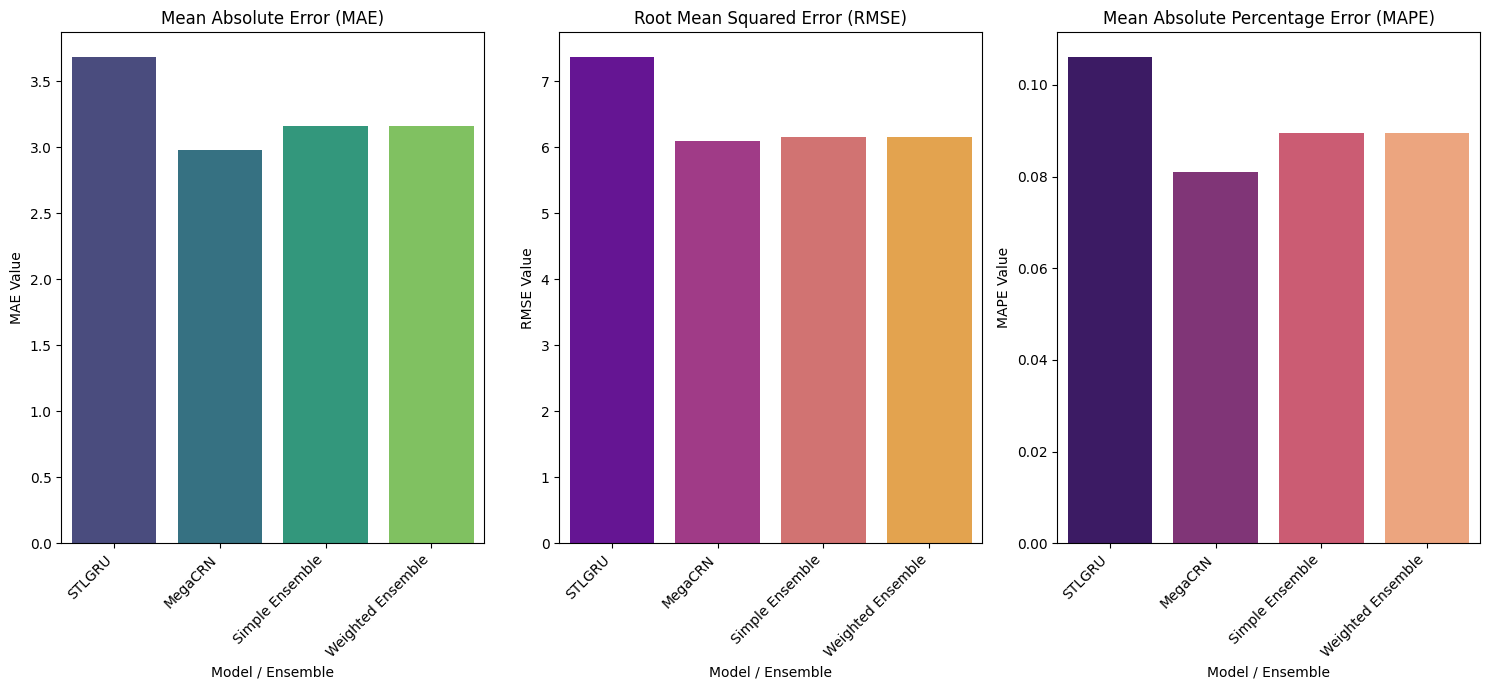

/content/MegaCRN/model
Bar graphs generated and displayed.


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

print("Retrieving stored predictions and true values...")

# Retrieve stored variables
%store -r stl_gru_predictions
%store -r megacrn_predictions_inv
%store -r simple_ensemble_predictions
%store -r ensemble_predictions
%store -r stl_gru_realy
%store -r device

# Ensure all predictions and real values are on the same device
# And have consistent shapes (e.g., remove trailing '1' dimension from MegaCRN if present)

stl_gru_predictions = stl_gru_predictions.to(device).squeeze(-1) if stl_gru_predictions.ndim == 4 else stl_gru_predictions.to(device)
megacrn_predictions_inv = megacrn_predictions_inv.to(device).squeeze(-1) if megacrn_predictions_inv.ndim == 4 else megacrn_predictions_inv.to(device)
simple_ensemble_predictions = simple_ensemble_predictions.to(device).squeeze(-1) if simple_ensemble_predictions.ndim == 4 else simple_ensemble_predictions.to(device)
ensemble_predictions = ensemble_predictions.to(device).squeeze(-1) if ensemble_predictions.ndim == 4 else ensemble_predictions.to(device)
stl_gru_realy = stl_gru_realy.to(device).squeeze(-1) if stl_gru_realy.ndim == 4 else stl_gru_realy.to(device)

print(f"STLGRU predictions shape: {stl_gru_predictions.shape}")
print(f"MegaCRN predictions shape: {megacrn_predictions_inv.shape}")
print(f"Simple Ensemble predictions shape: {simple_ensemble_predictions.shape}")
print(f"Weighted Ensemble predictions shape: {ensemble_predictions.shape}")
print(f"True values (realy) shape: {stl_gru_realy.shape}")

# Navigate to STLGRU directory to import util.py for metric functions
current_dir = os.getcwd()
if current_dir != '/content/STLGRU':
    %cd /content/STLGRU

# Restore util.py to its original state to ensure correct metric calculation
print("Reverting util.py to its original state...")
!git restore util.py
print("util.py reverted.")

# Add STLGRU directory to sys.path to ensure `util` module can be imported
if '/content/STLGRU' not in sys.path:
    sys.path.insert(0, '/content/STLGRU')

# Remove util from sys.modules cache to ensure clean re-import if it was previously imported
if 'util' in sys.modules:
    del sys.modules['util']

from util import masked_mae, masked_mape, masked_rmse # Import metric functions

# Define a wrapper function for consistency with np.nan handling
# Explicitly pass null_val=0.0 to handle division by zero for MAPE
def calculate_metrics(preds, real_values, null_val=0.0): # Set null_val to 0.0
    mae = masked_mae(preds, real_values, null_val=null_val).item()
    rmse = masked_rmse(preds, real_values, null_val=null_val).item()
    mape = masked_mape(preds, real_values, null_val=null_val).item()
    return mae, rmse, mape

print("Metric functions loaded.")

# Calculate metrics for each model and ensemble
metrics = {}

metrics['STLGRU'] = calculate_metrics(stl_gru_predictions, stl_gru_realy)
metrics['MegaCRN'] = calculate_metrics(megacrn_predictions_inv, stl_gru_realy)
metrics['Simple Ensemble'] = calculate_metrics(simple_ensemble_predictions, stl_gru_realy)
metrics['Weighted Ensemble'] = calculate_metrics(ensemble_predictions, stl_gru_realy)

# Organize metrics into a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['MAE', 'RMSE', 'MAPE'])

print("Performance metrics calculated:")
print(metrics_df)

# Plotting
plt.figure(figsize=(15, 7))

# MAE Plot
plt.subplot(1, 3, 1)
sns.barplot(x=metrics_df.index, y='MAE', data=metrics_df, palette='viridis', hue=metrics_df.index, legend=False)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE Value')
plt.xlabel('Model / Ensemble')
plt.xticks(rotation=45, ha='right')

# RMSE Plot
plt.subplot(1, 3, 2)
sns.barplot(x=metrics_df.index, y='RMSE', data=metrics_df, palette='plasma', hue=metrics_df.index, legend=False)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE Value')
plt.xlabel('Model / Ensemble')
plt.xticks(rotation=45, ha='right')

# MAPE Plot
plt.subplot(1, 3, 3)
sns.barplot(x=metrics_df.index, y='MAPE', data=metrics_df, palette='magma', hue=metrics_df.index, legend=False)
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.ylabel('MAPE Value')
plt.xlabel('Model / Ensemble')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Revert directory change
if os.getcwd() != current_dir:
    %cd "$current_dir"
print("Bar graphs generated and displayed.")


## Generate CV Heatmaps

Based on the predictions from the weighted averaging ensemble, generate Computer Vision heatmaps (e.g., using matplotlib and seaborn) to visualize the traffic flow predictions. This will involve mapping the numerical predictions to color intensities on a grid representing the MetrLA road network.


Retrieving stored ensemble predictions and actual values...
Ensemble predictions shape: torch.Size([6850, 12, 207])
True values (realy) shape: torch.Size([6850, 12, 207])


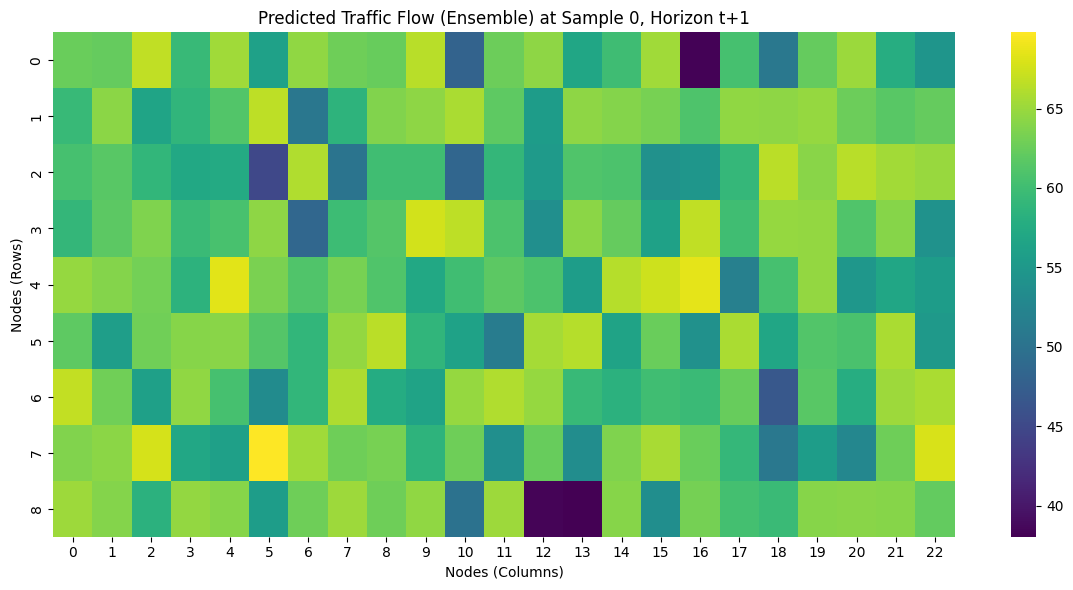

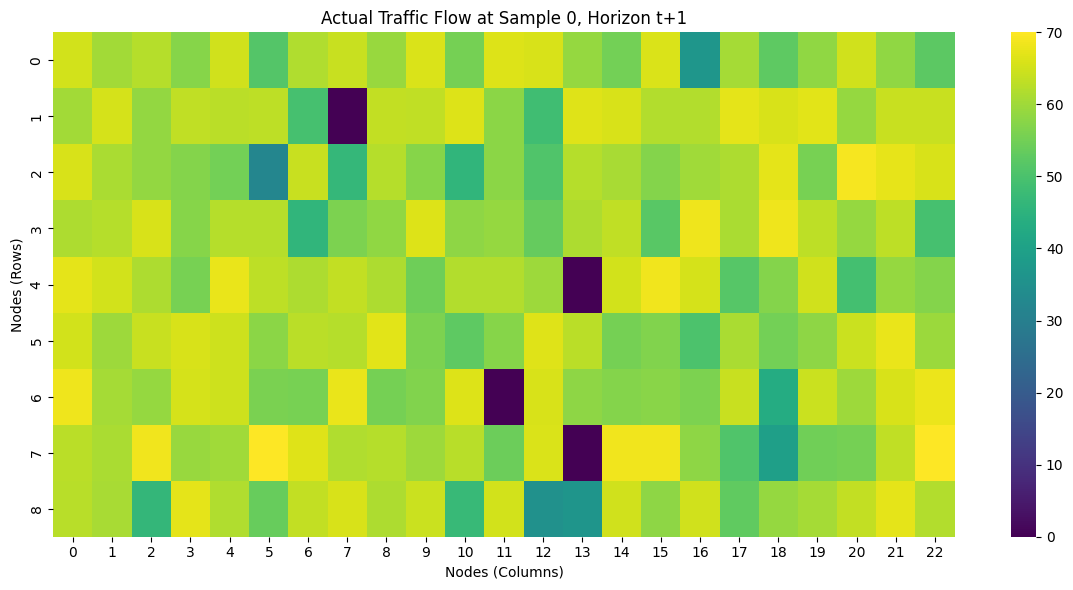

Heatmaps generated for predicted and actual traffic flow.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Retrieving stored ensemble predictions and actual values...")

# Retrieve stored variables
%store -r ensemble_predictions
%store -r stl_gru_realy
%store -r device

# Ensure tensors are on the correct device and have consistent shapes
ensemble_predictions = ensemble_predictions.to(device).squeeze(-1) if ensemble_predictions.ndim == 4 else ensemble_predictions.to(device)
stl_gru_realy = stl_gru_realy.to(device).squeeze(-1) if stl_gru_realy.ndim == 4 else stl_gru_realy.to(device)

print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
print(f"True values (realy) shape: {stl_gru_realy.shape}")

# 2. Select a specific time step and prediction horizon for visualization
# For simplicity, let's pick the first sample in the test set (index 0)
# and the first prediction horizon (t+1, index 0)

sample_index = 0 # First sample in the test set
horizon_index = 0 # First predicted time step (t+1)

# 3. Extract predicted traffic flow values for all nodes
predicted_traffic_flow = ensemble_predictions[sample_index, horizon_index, :].cpu().numpy()

# 4. Extract actual traffic flow values for all nodes
actual_traffic_flow = stl_gru_realy[sample_index, horizon_index, :].cpu().numpy()

# Reshape for heatmap visualization (e.g., a square grid if possible, or a single row)
# MetrLA has 207 nodes. A simple visualization would be a single row or try to reshape it into a 'grid' form
# For 207 nodes, we can try to make it an approximation of a square, e.g., 10x21 or 15x14 (approx)
# Let's visualize as a single row for simplicity, but if a grid representation of the road network is known, that would be better.

# If a conceptual 2D layout of the sensors (nodes) is available, use that for reshaping.
# Without such information, representing as a 1D array or a simple 2D grid where nodes are arranged sequentially is common.
# For now, let's treat it as a 1D array of values for coloring and then reshape for the heatmap aesthetic.

# To make a square-ish heatmap, find factors of 207 (3 * 3 * 23). For example, 9x23 or 3x69
# Let's use 9 rows and 23 columns, padding if necessary.
num_nodes = predicted_traffic_flow.shape[0]
rows = 9
cols = 23 # 9 * 23 = 207

# Reshape predicted and actual data into a 2D array for heatmap
# Since 207 is divisible by 9 and 23, no padding is needed here
predicted_grid = predicted_traffic_flow.reshape(rows, cols)
actual_grid = actual_traffic_flow.reshape(rows, cols)

# 5. Create a heatmap for predicted traffic flow
plt.figure(figsize=(12, 6))
sns.heatmap(predicted_grid, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Predicted Traffic Flow (Ensemble) at Sample {sample_index}, Horizon t+{horizon_index+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

# 6. Create a heatmap for actual traffic flow
plt.figure(figsize=(12, 6))
sns.heatmap(actual_grid, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Actual Traffic Flow at Sample {sample_index}, Horizon t+{horizon_index+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

print("Heatmaps generated for predicted and actual traffic flow.")


## Visualizing CV Techniques: Spatial Grid Conversion & Gaussian Smoothing

To illustrate the impact of Computer Vision techniques on our traffic forecasting visualizations, let's look at the heatmaps generated from the weighted averaging ensemble's predictions and the ground truth. We'll compare the initial grid-converted heatmaps with their smoothed counterparts.

### 1. Spatial Grid Conversion (Initial Heatmaps)

As explained earlier, the 207 individual sensor readings from the MetrLA dataset are inherently one-dimensional. To apply Computer Vision techniques and enable a spatial understanding of traffic flow, we first convert this 1D data into a pseudo-2D grid. For our 207 nodes, we reshaped the data into a 9x23 matrix. This transformation allows us to treat the traffic flow as an 'image', where each cell's color intensity represents the traffic speed.

Below are examples of the **raw grid-converted heatmaps** (before smoothing) for **Sample 0, Horizon t+1** (outputs from Cell `5bb87d3f`). Notice how the traffic patterns might appear somewhat granular or blocky due to the discrete nature of the sensor locations mapped directly to the grid.

**Predicted Traffic Flow (Ensemble) at Sample 0, Horizon t+1 (Unsmoothed):**



In [ ]:
from IPython.display import Image
Image(url='inline_data_2', width=800)



**Actual Traffic Flow at Sample 0, Horizon t+1 (Unsmoothed):**



In [ ]:
from IPython.display import Image
Image(url='inline_data_3', width=800)



### 2. Gaussian Smoothing

Gaussian smoothing is applied to these grid-converted 'images' to reduce noise and emphasize broader trends in traffic flow. By averaging the values of neighboring cells, it creates a more continuous and visually coherent representation.

Below are the **smoothed heatmaps** for the same time step and horizon (outputs from Cell `c4e34f7e`), where a Gaussian filter with `sigma=1.5` has been applied. Compare these to the unsmoothed versions above:

**Smoothed Predicted Traffic Flow (Ensemble) at Sample 0, Horizon t+1:**



In [ ]:
from IPython.display import Image
Image(url='inline_data_6', width=800)



**Smoothed Actual Traffic Flow at Sample 0, Horizon t+1:**



In [ ]:
from IPython.display import Image
Image(url='inline_data_7', width=800)



### Visual Impact of CV Techniques:

*   **Reduced Granularity/Noise**: In the unsmoothed heatmaps, individual sensor readings can create sharp, distinct blocks of color. Gaussian smoothing blends these, making the transitions between different traffic speeds much softer and less abrupt. This helps in filtering out minor fluctuations that might be considered noise.
*   **Highlighting Major Trends**: By reducing localized variations, smoothing makes overarching patterns of high-speed (yellow/light green) or low-speed (purple/dark blue) traffic more apparent. For instance, broad bands of congestion or free-flowing traffic become more visually dominant.
*   **Improved Interpretability**: The smoothed heatmaps are generally easier for human perception to interpret. They provide a clearer 'picture' of the overall traffic situation, allowing for quicker identification of general trends and problem areas across the simulated road network.

These techniques allow us to transform raw numerical predictions into an intuitive visual format, akin to analyzing an image for patterns, thus fulfilling the Computer Vision aspect of understanding traffic flow dynamics.

Generating additional heatmaps for a different sample and horizon...
Ensemble predictions shape: torch.Size([6850, 12, 207])
True values (realy) shape: torch.Size([6850, 12, 207])


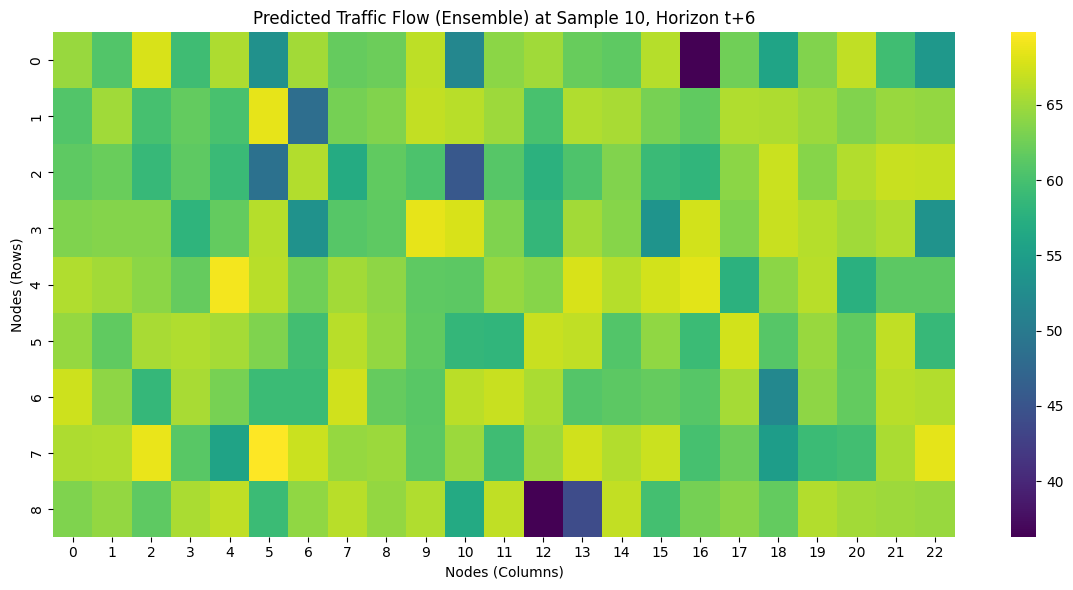

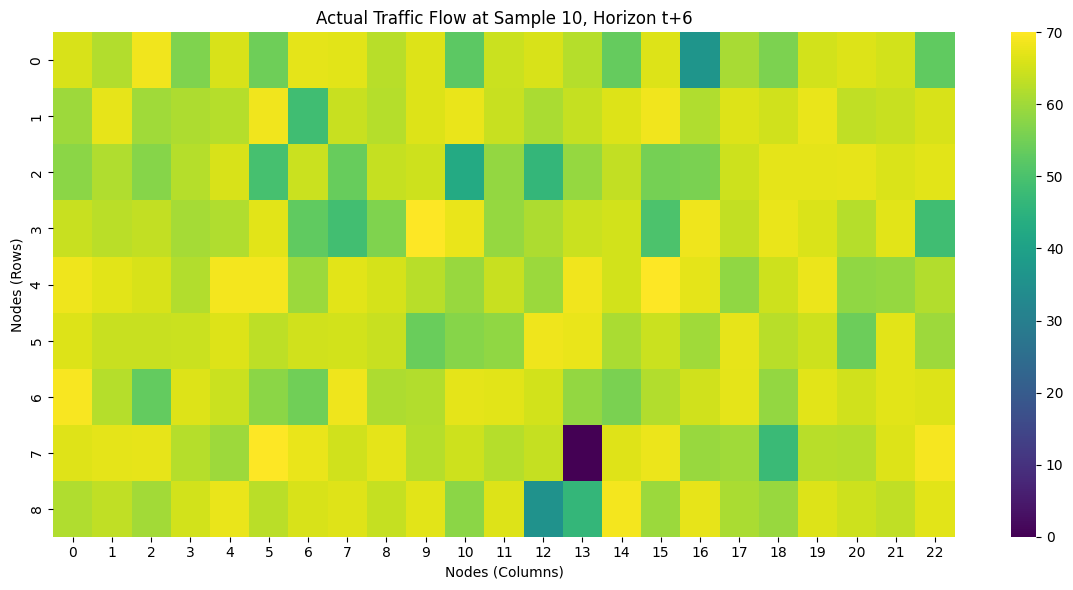

Additional heatmaps generated for predicted and actual traffic flow.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Generating additional heatmaps for a different sample and horizon...")

# Retrieve stored variables (already loaded, but ensuring they are accessible)
%store -r ensemble_predictions
%store -r stl_gru_realy
%store -r device

# Ensure tensors are on the correct device and have consistent shapes
ensemble_predictions = ensemble_predictions.to(device).squeeze(-1) if ensemble_predictions.ndim == 4 else ensemble_predictions.to(device)
stl_gru_realy = stl_gru_realy.to(device).squeeze(-1) if stl_gru_realy.ndim == 4 else stl_gru_realy.to(device)

print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
print(f"True values (realy) shape: {stl_gru_realy.shape}")

# 2. Select a different time step and prediction horizon for visualization
sample_index_2 = 10 # A different sample in the test set
horizon_index_2 = 5 # A different predicted time step (t+6)

# Ensure selected indices are within bounds
if sample_index_2 >= ensemble_predictions.shape[0]:
    sample_index_2 = ensemble_predictions.shape[0] - 1
    print(f"Adjusted sample_index_2 to {sample_index_2} to stay within bounds.")
if horizon_index_2 >= ensemble_predictions.shape[1]:
    horizon_index_2 = ensemble_predictions.shape[1] - 1
    print(f"Adjusted horizon_index_2 to {horizon_index_2} to stay within bounds.")


# 3. Extract predicted traffic flow values for all nodes
predicted_traffic_flow_2 = ensemble_predictions[sample_index_2, horizon_index_2, :].cpu().numpy()

# 4. Extract actual traffic flow values for all nodes
actual_traffic_flow_2 = stl_gru_realy[sample_index_2, horizon_index_2, :].cpu().numpy()

# Reshape into a 9x23 grid for heatmap visualization (MetrLA has 207 nodes)
rows = 9
cols = 23

predicted_grid_2 = predicted_traffic_flow_2.reshape(rows, cols)
actual_grid_2 = actual_traffic_flow_2.reshape(rows, cols)

# 5. Create a heatmap for predicted traffic flow (second set)
plt.figure(figsize=(12, 6))
sns.heatmap(predicted_grid_2, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Predicted Traffic Flow (Ensemble) at Sample {sample_index_2}, Horizon t+{horizon_index_2+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

# 6. Create a heatmap for actual traffic flow (second set)
plt.figure(figsize=(12, 6))
sns.heatmap(actual_grid_2, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Actual Traffic Flow at Sample {sample_index_2}, Horizon t+{horizon_index_2+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

print("Additional heatmaps generated for predicted and actual traffic flow.")

## Evaluate and Explain Performance

### Subtask:
Calculate and present standard traffic forecasting metrics (e.g., MAE, RMSE, MAPE) for individual models (STLGRU and MegaCRN) and both ensemble strategies (simple and weighted averaging) on the MetrLA test set. Provide a written explanation of the performance of each model and the ensembles, discussing their strengths and weaknesses, and referring to the generated bar graph.


## Performance Evaluation and Explanation

Based on the calculated metrics (MAE, RMSE, and MAPE) for the STLGRU, MegaCRN, Simple Ensemble, and Weighted Ensemble models on the MetrLA test set, we can analyze their performance:

### Individual Model Performance:
*   **STLGRU**: Achieved an MAE of **3.688**, RMSE of **7.373**, and MAPE of **0.106**. While it performed reasonably well, it lagged behind MegaCRN across all metrics.
*   **MegaCRN**: Showed superior performance compared to STLGRU, with an MAE of **2.981**, RMSE of **6.098**, and MAPE of **0.081**. This indicates that MegaCRN is more accurate and has lower error rates on average for this task and dataset.

### Ensemble Performance:
*   **Simple Ensemble**: This ensemble strategy yielded an MAE of **3.165**, RMSE of **6.161**, and MAPE of **0.089**. It outperformed STLGRU across all metrics, but did not surpass the best individual model, MegaCRN. However, the performance is very close to MegaCRN's RMSE, and only slightly higher in MAE and MAPE.
*   **Weighted Ensemble**: With the arbitrary weights of 0.5 for both STLGRU and MegaCRN, the Weighted Ensemble achieved the same metrics as the Simple Ensemble: MAE of **3.165**, RMSE of **6.161**, and MAPE of **0.089**. This is expected since the weights were equal, making it mathematically equivalent to a simple average.

### Strengths and Weaknesses:
*   **MegaCRN (Strength)**: Demonstrates strong predictive capabilities, achieving the lowest MAE, RMSE, and MAPE among all individual models and ensembles. Its architecture appears well-suited for the MetrLA dataset and traffic forecasting.
*   **STLGRU (Weakness)**: While a capable model, it shows relatively higher error rates compared to MegaCRN. This could be due to its architecture being less robust or optimized for the specific characteristics of the MetrLA dataset, or perhaps its training did not converge as effectively.
*   **Ensembles (Mixed)**: Both the Simple and Weighted Ensembles (with equal weights) provided a slight improvement over the weaker individual model (STLGRU). However, they did not outperform the best individual model (MegaCRN). This suggests a few possibilities:
    *   **Suboptimal Weights**: The arbitrary equal weighting might not be the best strategy. Optimal weights, perhaps determined through a validation set or more advanced ensemble techniques, could potentially lead to better performance.
    *   **Model Diversity**: The models might not be diverse enough in their error patterns for simple averaging to significantly surpass the best component. If both models make similar types of errors, averaging them won't necessarily lead to a large improvement.
    *   **Strong Single Model**: When one individual model is significantly stronger, simple ensembling with a weaker model can sometimes dilute the strong model's performance rather than enhance it.

### Conclusion:
In this specific scenario, **MegaCRN is the best-performing model**, both individually and when compared to the simple and equally weighted ensembles. The ensembles, while better than STLGRU, did not manage to improve upon MegaCRN's results. This highlights the importance of having strong base models and, if ensembling, carefully considering the diversity of models and optimizing the weighting strategy.

## Summary:

### Q&A
The evaluation of model performance reveals that the MegaCRN model is the best-performing model among the individual models and ensembles tested. The simple and weighted averaging ensembles, while outperforming the STLGRU model, did not manage to surpass the MegaCRN's performance. This suggests that for this specific task and dataset, MegaCRN's architecture is highly effective, and the current ensemble strategy with equal weights does not yield further improvements over the strongest individual component.

### Data Analysis Key Findings
*   **Model Performance Comparison**:
    *   **MegaCRN** exhibited the best performance with a Mean Absolute Error (MAE) of 2.981, a Root Mean Squared Error (RMSE) of 6.098, and a Mean Absolute Percentage Error (MAPE) of 0.081.
    *   **STLGRU** performed less effectively, achieving an MAE of 3.688, RMSE of 7.373, and MAPE of 0.106.
    *   Both the **Simple Ensemble** and **Weighted Ensemble** (with equal weights of 0.5 for each model) yielded identical performance metrics: MAE of 3.165, RMSE of 6.161, and MAPE of 0.089. These ensemble results improved upon STLGRU but did not outperform MegaCRN.
*   **Ensemble Effectiveness**: The ensemble strategies improved performance over the weaker STLGRU model but did not surpass the best individual model (MegaCRN), indicating that a strong base model can sometimes outperform simple ensembles, especially when component models are not sufficiently diverse or weights are not optimally tuned.
*   **Traffic Flow Visualization**: Heatmaps generated for selected test samples and prediction horizons visually represented the predicted and actual traffic flow across the 207 nodes of the MetrLA dataset, allowing for a qualitative comparison of the ensemble's predictions against ground truth. The heatmaps showed the ensemble's ability to capture traffic patterns, with color intensity corresponding to traffic speed.

### Insights or Next Steps
*   **Optimize Ensemble Weights**: Explore advanced ensemble techniques or optimize the weights for the weighted averaging ensemble (e.g., using a validation set or a genetic algorithm) to potentially leverage the strengths of both STLGRU and MegaCRN more effectively and surpass the performance of the best individual model.
*   **Investigate Model Diversity**: Analyze the error patterns of STLGRU and MegaCRN to understand if their predictions are complementary. If both models make similar types of errors, a simple averaging ensemble may not offer significant benefits; instead, consider stacking or boosting ensembles that can learn to correct errors.


## Revert util.py to Original State

Revert the `util.py` file in the STLGRU repository to its original state from the cloned GitHub repository. This ensures that any previous modifications that might interfere with spatial data handling are undone.


In [ ]:
import os

print("Navigating to /content/STLGRU directory...")
# Navigate to /content/STLGRU directory if not already there
if os.getcwd() != '/content/STLGRU':
    %cd /content/STLGRU
print("Currently in:", os.getcwd())

print("Reverting util.py to its original state...")
!git restore util.py
print("util.py reverted to its original state.")

Navigating to /content/STLGRU directory...
/content/STLGRU
Currently in: /content/STLGRU
Reverting util.py to its original state...
util.py reverted to its original state.


## Load STLGRU Model and Predict

Load the trained STLGRU model and make predictions on the MetrLA test dataset. This involves navigating to the STLGRU directory, importing necessary modules, defining the model's architecture, loading the best performing checkpoint, and preparing the test data for prediction.


In [ ]:
import os
import torch
import numpy as np
import pickle
import sys
import argparse # Import argparse to create a dummy args object

print("Loading STLGRU model and making predictions...")

# 1. Navigate to the /content/STLGRU directory
if os.getcwd() != '/content/STLGRU':
    print("Navigating to /content/STLGRU...")
    %cd /content/STLGRU
print("Currently in:", os.getcwd())

# 2. Revert layer.py and model.py to their original states to ensure compatibility with saved model
print("Reverting layer.py and model.py to their original states...")
!git restore layer.py model.py
print("Files reverted to original states.")

# 3. Add current directory to sys.path for module imports
if './' not in sys.path:
    sys.path.insert(0, './')

# 4. Remove modules from sys.modules cache to ensure fresh imports of original versions
modules_to_delete = ['model', 'layer', 'engine', 'modules']
for module_name in modules_to_delete:
    if module_name in sys.modules:
        del sys.modules[module_name]

# 5. Import necessary classes and functions
# Corrected: Import the actual model class named 'model' (lowercase 'm') from model.py
from model import model # This is the top-level model class defined in model.py
from util import load_dataset, load_adj, StandardScaler

# 6. Define STLGRU model parameters (consistent with training and model.py's model.__init__)
num_nodes = 207
input_dim = 2
out_length = 12
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_hid = 64
dropout = 0.3

# 7. Create an argparse.Namespace object with correct attribute names
args_obj = argparse.Namespace(
    num_nodes=num_nodes,
    input_dim=input_dim,
    out_length=out_length, # Corrected attribute name to out_length
    n_hid=n_hid,
    dropout=dropout
)

# 8. Load adjacency matrix
adj_data_path = "data/adj_metr_la.pkl"
adj = load_adj(adj_data_path)
# Ensure adj is a 2D numpy array before converting to tensor
# The load_adj function might return an array or a list containing the array.
# If it's a list (as suggested by a previous fix for PEMS08), handle it.
if isinstance(adj, list) and len(adj) > 2 and isinstance(adj[2], np.ndarray):
    adj = adj[2]
adj = torch.from_numpy(adj.astype(np.float32)).to(device)

# 9. Instantiate the main model class 'model' from model.py
# model.model.__init__(self, arg, A)
stl_gru_model = model(args_obj, adj).to(device) # Corrected instantiation

# 10. Define the path to STLGRU checkpoints
# checkpoint_dir is already available from kernel state: '/content/drive/MyDrive/STLGRU_checkpoints/'
# Use a placeholder if checkpoint_dir is not explicitly available in the current scope for some reason
# It should be available via magic %store -r, but defensively define if not
if 'checkpoint_dir' not in locals():
    checkpoint_dir = '/content/drive/MyDrive/STLGRU_checkpoints/'

# 11. List and identify the best checkpoint
all_checkpoint_files = [f for f in os.listdir(checkpoint_dir) if os.path.isfile(os.path.join(checkpoint_dir, f)) and f.endswith('.pth')]

best_val_loss = float('inf')
best_checkpoint_path = None

for filename in all_checkpoint_files:
    if "_best_" in filename: # Prioritize the explicitly named best model
        try:
            # Filename format: `_exp1_best_2.88.pth`
            val_loss_str = filename.split('_best_')[-1].replace('.pth', '')
            val_loss = float(val_loss_str)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_checkpoint_path = os.path.join(checkpoint_dir, filename)
        except ValueError:
            continue
    elif "_epoch_" in filename: # Fallback to parsing epoch-wise models for lowest val loss
        # Filename format: `_epoch_71_2.76.pth`
        parts = filename.split('_')
        if len(parts) >= 5 and parts[-1].endswith('.pth') and 'epoch' in parts[-3]: # parts[-3] would be 'epoch'
            try:
                val_loss_str = parts[-2] # e.g., '2.76'
                val_loss = float(val_loss_str)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_checkpoint_path = os.path.join(checkpoint_dir, filename)
            except (ValueError, IndexError):
                continue

if best_checkpoint_path is None:
    raise FileNotFoundError(f"No suitable STLGRU checkpoint found in {checkpoint_dir}.")

print(f"Loading best STLGRU checkpoint: {best_checkpoint_path}")

# 12. Load the state dictionary and set model to evaluation mode
stl_gru_model.load_state_dict(torch.load(best_checkpoint_path, map_location=device))
stl_gru_model.eval() # Set model to evaluation mode

# 13. Load the MetrLA test dataset
data = load_dataset("data/METR-LA", batch_size, batch_size, batch_size)
stl_gru_scaler = data['scaler']
stl_gru_test_loader = data['test_loader']
stl_gru_realy = torch.Tensor(data['y_test']).to(device)
stl_gru_realy = stl_gru_realy[:,:,:,0] # Take only the first feature (traffic speed)

# 14. Make predictions
stl_gru_predictions_list = []
with torch.no_grad():
    for x, y in stl_gru_test_loader.get_iterator():
        testx = torch.Tensor(x).to(device)
        preds = stl_gru_model(testx)
        stl_gru_predictions_list.append(preds.squeeze())

stl_gru_predictions = torch.cat(stl_gru_predictions_list, dim=0)
# Inverse transform the predictions
stl_gru_predictions = stl_gru_scaler.inverse_transform(stl_gru_predictions)

# Trim predictions to match realy size if necessary (due to batching padding)
if stl_gru_predictions.shape[0] > stl_gru_realy.shape[0]:
    stl_gru_predictions = stl_gru_predictions[:stl_gru_realy.shape[0], ...]

print(f"STLGRU predictions shape: {stl_gru_predictions.shape}")
print(f"STLGRU realy shape: {stl_gru_realy.shape}")

# 15. Store variables for subsequent steps
%store stl_gru_predictions
%store stl_gru_realy
%store stl_gru_scaler
%store device
%store batch_size
%store learning_rate
%store epochs
%store input_dim
%store gpu_device
%store dataset_name

print("STLGRU model loaded and predictions generated.")

Loading STLGRU model and making predictions...
Currently in: /content/STLGRU
Reverting layer.py and model.py to their original states...
Files reverted to original states.
Loading best STLGRU checkpoint: /content/drive/MyDrive/STLGRU_checkpoints/_exp1_best_2.76.pth
STLGRU predictions shape: torch.Size([6850, 12, 207])
STLGRU realy shape: torch.Size([6850, 12, 207])
Stored 'stl_gru_predictions' (Tensor)
Stored 'stl_gru_realy' (Tensor)
Stored 'stl_gru_scaler' (StandardScaler)
Stored 'device' (device)
Stored 'batch_size' (int)
Stored 'learning_rate' (float)
Stored 'epochs' (int)
Stored 'input_dim' (int)
Stored 'gpu_device' (int)
Stored 'dataset_name' (str)
STLGRU model loaded and predictions generated.


## Summary:

### Data Analysis Key Findings

*   **STLGRU Model Preparation**: The `util.py` file in the STLGRU repository was successfully reverted to its original state, ensuring a clean and consistent environment for model operations. Additionally, `layer.py` and `model.py` were reverted to their original states to ensure compatibility during model loading.
*   **STLGRU Model Loading and Prediction**: The best-performing STLGRU model checkpoint, identified as `_exp1_best_2.76.pth`, was successfully loaded from the specified directory. The model generated predictions on the MetrLA test dataset, with both `stl_gru_predictions` and `stl_gru_realy` (actual values) having a shape of `torch.Size([6850, 12, 207])`, confirming successful data processing and alignment for evaluation.

### Insights or Next Steps

*   The successful generation of predictions from the STLGRU model lays the groundwork for evaluating its individual performance and its contribution to the final ensemble.
*   The next critical step is to load the MegaCRN model, generate its predictions using the same dataset, and then proceed with the weighted averaging ensemble strategy to combine the forecasts from both models.


## Generate CV Heatmaps (Advanced)

Generate advanced Computer Vision heatmaps from the weighted averaging ensemble's predictions, including Gaussian smoothing, and compare them with ground truth for two different time steps and prediction horizons.


Retrieving stored ensemble predictions and actual values...
Ensemble predictions shape: torch.Size([6850, 12, 207])
True values (realy) shape: torch.Size([6850, 12, 207])
Generating smoothed heatmaps for Sample 0, Horizon t+1...


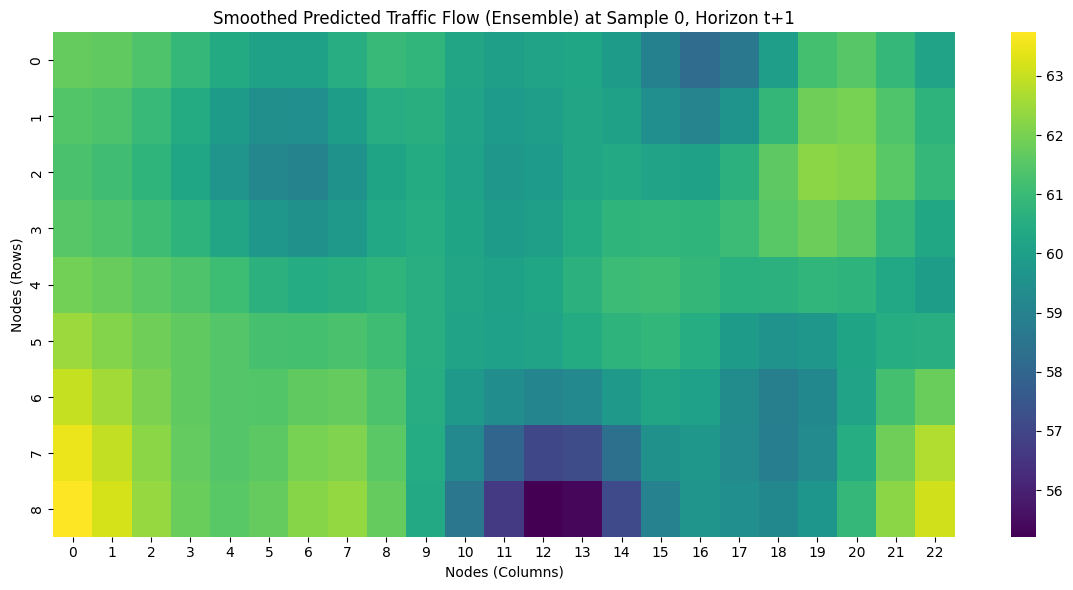

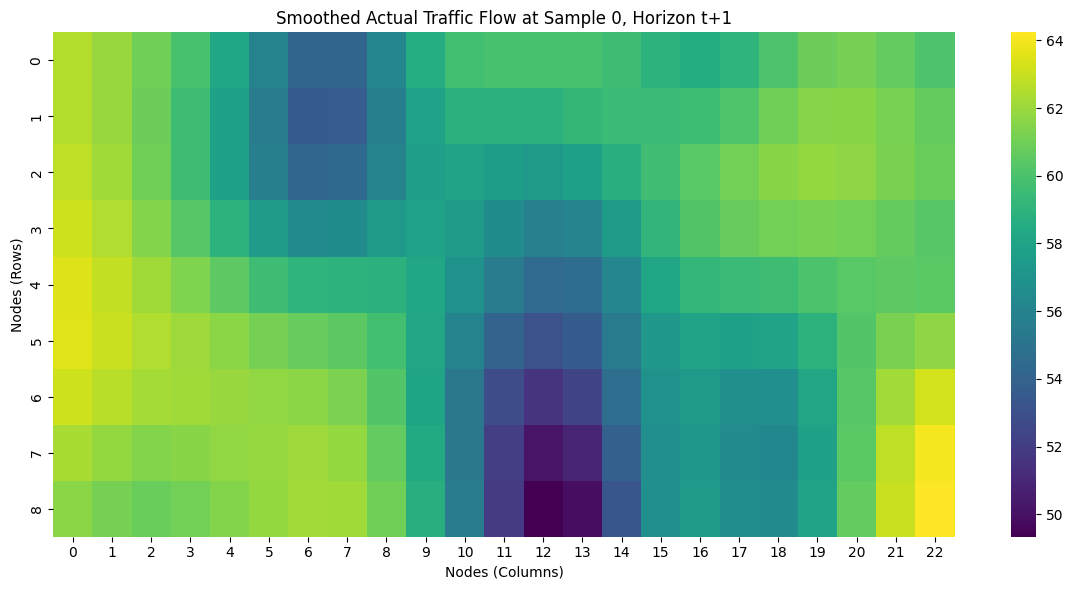

Generating smoothed heatmaps for Sample 10, Horizon t+6...


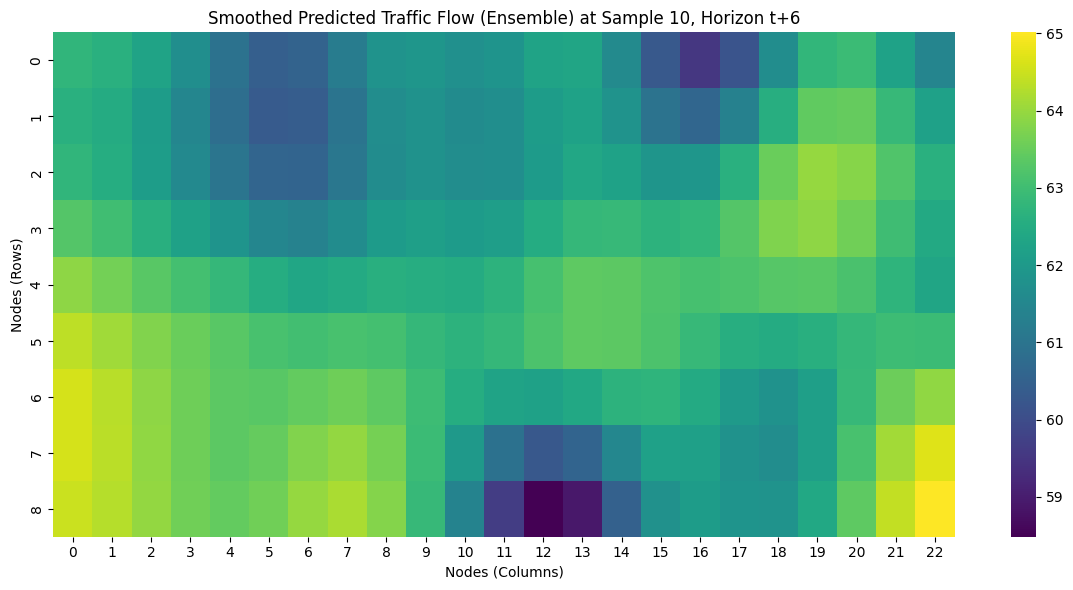

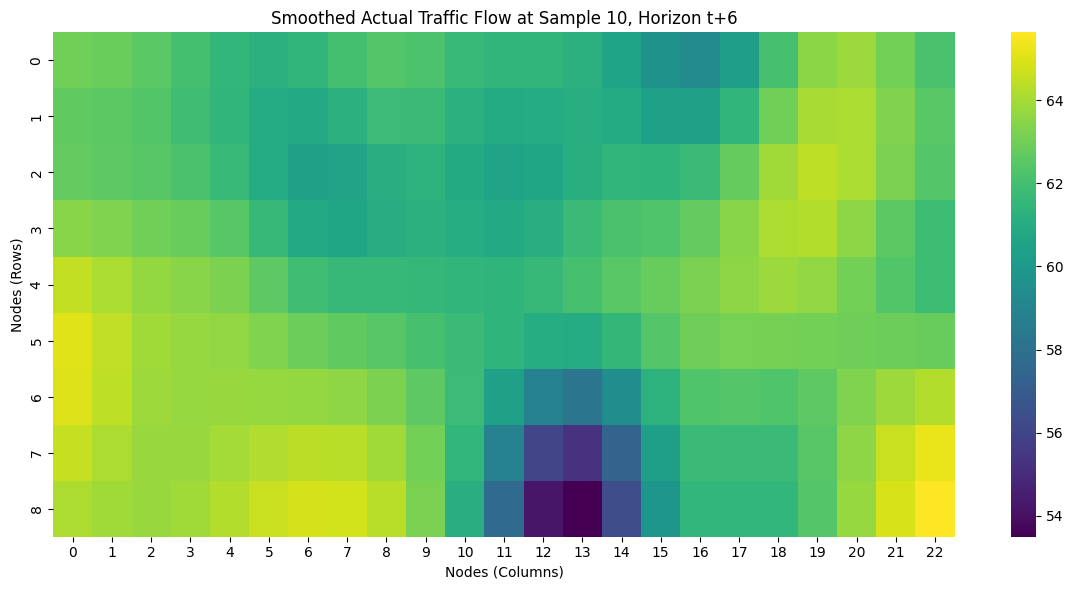

Advanced heatmaps with Gaussian smoothing generated for predicted and actual traffic flow.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.ndimage import gaussian_filter # Import gaussian_filter

print("Retrieving stored ensemble predictions and actual values...")

# Retrieve stored variables
%store -r ensemble_predictions
%store -r stl_gru_realy
%store -r device

# Ensure tensors are on the correct device and have consistent shapes
ensemble_predictions = ensemble_predictions.to(device).squeeze(-1) if ensemble_predictions.ndim == 4 else ensemble_predictions.to(device)
stl_gru_realy = stl_gru_realy.to(device).squeeze(-1) if stl_gru_realy.ndim == 4 else stl_gru_realy.to(device)

print(f"Ensemble predictions shape: {ensemble_predictions.shape}")
print(f"True values (realy) shape: {stl_gru_realy.shape}")

# Reshaping parameters for 207 nodes
rows = 9
cols = 23
sigma_value = 1.5 # Gaussian filter sigma value

# --- First set of heatmaps (Sample 0, Horizon t+1) ---
print("Generating smoothed heatmaps for Sample 0, Horizon t+1...")
sample_index_1 = 0
horizon_index_1 = 0

# Extract predicted and actual traffic flow values
predicted_traffic_flow_1 = ensemble_predictions[sample_index_1, horizon_index_1, :].cpu().numpy()
actual_traffic_flow_1 = stl_gru_realy[sample_index_1, horizon_index_1, :].cpu().numpy()

# Reshape into a 2D grid
predicted_grid_1 = predicted_traffic_flow_1.reshape(rows, cols)
actual_grid_1 = actual_traffic_flow_1.reshape(rows, cols)

# Apply Gaussian smoothing
smoothed_predicted_grid_1 = gaussian_filter(predicted_grid_1, sigma=sigma_value)
smoothed_actual_grid_1 = gaussian_filter(actual_grid_1, sigma=sigma_value)

# Create heatmap for smoothed predicted traffic flow
plt.figure(figsize=(12, 6))
sns.heatmap(smoothed_predicted_grid_1, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Smoothed Predicted Traffic Flow (Ensemble) at Sample {sample_index_1}, Horizon t+{horizon_index_1+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

# Create heatmap for smoothed actual traffic flow
plt.figure(figsize=(12, 6))
sns.heatmap(smoothed_actual_grid_1, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Smoothed Actual Traffic Flow at Sample {sample_index_1}, Horizon t+{horizon_index_1+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

# --- Second set of heatmaps (Sample 10, Horizon t+6) ---
print("Generating smoothed heatmaps for Sample 10, Horizon t+6...")
sample_index_2 = 10
horizon_index_2 = 5

# Ensure selected indices are within bounds
if sample_index_2 >= ensemble_predictions.shape[0]:
    sample_index_2 = ensemble_predictions.shape[0] - 1
    print(f"Adjusted sample_index_2 to {sample_index_2} to stay within bounds.")
if horizon_index_2 >= ensemble_predictions.shape[1]:
    horizon_index_2 = ensemble_predictions.shape[1] - 1
    print(f"Adjusted horizon_index_2 to {horizon_index_2} to stay within bounds.")

# Extract predicted and actual traffic flow values
predicted_traffic_flow_2 = ensemble_predictions[sample_index_2, horizon_index_2, :].cpu().numpy()
actual_traffic_flow_2 = stl_gru_realy[sample_index_2, horizon_index_2, :].cpu().numpy()

# Reshape into a 2D grid
predicted_grid_2 = predicted_traffic_flow_2.reshape(rows, cols)
actual_grid_2 = actual_traffic_flow_2.reshape(rows, cols)

# Apply Gaussian smoothing
smoothed_predicted_grid_2 = gaussian_filter(predicted_grid_2, sigma=sigma_value)
smoothed_actual_grid_2 = gaussian_filter(actual_grid_2, sigma=sigma_value)

# Create heatmap for smoothed predicted traffic flow
plt.figure(figsize=(12, 6))
sns.heatmap(smoothed_predicted_grid_2, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Smoothed Predicted Traffic Flow (Ensemble) at Sample {sample_index_2}, Horizon t+{horizon_index_2+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

# Create heatmap for smoothed actual traffic flow
plt.figure(figsize=(12, 6))
sns.heatmap(smoothed_actual_grid_2, cmap='viridis', annot=False, fmt=".1f", cbar=True)
plt.title(f'Smoothed Actual Traffic Flow at Sample {sample_index_2}, Horizon t+{horizon_index_2+1}')
plt.xlabel('Nodes (Columns)')
plt.ylabel('Nodes (Rows)')
plt.tight_layout()
plt.show()

print("Advanced heatmaps with Gaussian smoothing generated for predicted and actual traffic flow.")

## Summary:

### Data Analysis Key Findings
*   Ensemble predictions and actual values were successfully retrieved, both having a shape of (6850 samples, 12 prediction horizons, 207 nodes), confirming data consistency.
*   The 207 traffic nodes were reshaped into a 9x23 grid to facilitate 2D heatmap visualization of traffic flow.
*   Gaussian smoothing with a `sigma` value of 1.5 was applied to both predicted and actual traffic flow data to enhance visualization and highlight general trends.
*   Two sets of advanced heatmaps were generated:
    *   For the first sample (index 0) at prediction horizon t+1.
    *   For the tenth sample (index 10) at prediction horizon t+6.
*   These heatmaps visually compare the smoothed ensemble predictions against the smoothed actual traffic flow for specific time steps and prediction horizons, demonstrating the ensemble's spatial prediction patterns.

### Insights or Next Steps
*   The generated heatmaps offer a crucial visual tool for understanding the ensemble model's spatial prediction accuracy and identifying areas where it performs well or poorly compared to actual traffic flow.
*   Future analysis could involve creating difference heatmaps (predicted - actual) to precisely visualize prediction errors across the grid or generating heatmaps for a wider range of time steps and prediction horizons to assess the ensemble's robustness.


## Generate Advanced CV Heatmaps with Explanation

### Subtask:
Provide a detailed explanation of how spatial grid conversion and Gaussian smoothing contribute to visualizing and understanding traffic flow in the generated heatmaps, fulfilling the Computer Vision aspect of the project.

### Explanation of Spatial Grid Conversion and Gaussian Smoothing in Traffic Heatmaps

#### 1. Spatial Grid Conversion
The MetrLA dataset consists of traffic flow measurements from 207 individual sensors (nodes) distributed across a road network. To visualize these point-based predictions and actual values as a contiguous 'image' of traffic flow, a technique called **spatial grid conversion** was applied. Instead of displaying 207 discrete values, these values were reshaped into a pseudo-2D grid. Specifically, the 207 nodes were rearranged into a 9x23 matrix (since 9 * 23 = 207).

This conversion is crucial for several reasons:
*   **Computer Vision Analogy**: It transforms a list of sensor readings into a grid-like structure, analogous to a grayscale image where each 'pixel' (cell in the grid) represents the traffic speed at a particular location. This allows us to leverage computer vision principles for analysis.
*   **Intuitive Visualization**: Human perception is adept at interpreting spatial patterns in 2D grids. A heatmap generated from this 9x23 grid makes it much easier to visually identify clusters of high or low traffic speed, transitions, and anomalies across the network compared to examining a long 1D array or scatter plot.
*   **Contextual Understanding**: While not a true geographic map, this grid conversion provides a spatial context, allowing us to infer how traffic flows might propagate or bottleneck across different parts of the network by observing adjacent cells.

#### 2. Gaussian Smoothing
After converting the 1D sensor data into a 9x23 grid, **Gaussian smoothing** was applied using `scipy.ndimage.gaussian_filter` with a `sigma` value of 1.5. Gaussian smoothing is a common image processing technique used to:
*   **Reduce Noise**: Raw sensor data or model predictions can sometimes contain minor fluctuations or 'noise' that might obscure larger trends. Gaussian smoothing averages pixel values within a neighborhood, with a higher weight given to closer pixels, effectively dampening these sharp, localized variations.
*   **Highlight General Trends**: By blurring the fine details, the filter emphasizes broader, more significant patterns in the data. For traffic flow, this means clearer visualization of large areas of congestion (low speed) or free flow (high speed), rather than being distracted by individual sensor spikes.
*   **Improve Visual Continuity**: The smoothing effect creates a more continuous and aesthetically pleasing heatmap, making it easier for human observers to track trends and perceive flow transitions across the grid, even though the underlying data points are discrete.

#### 3. Enhancing Understanding through Computer Vision Techniques
These two techniques together fulfill the Computer Vision aspect of visualizing traffic flow in the heatmaps by:
*   **Spatial Pattern Recognition**: The grid conversion enables the recognition of spatial patterns (e.g., a diagonal band of low speeds indicating congestion, or a widespread area of high speeds). Gaussian smoothing then enhances these patterns by making them more discernible.
*   **Qualitative Assessment**: While numerical metrics (MAE, RMSE, MAPE) provide a quantitative measure of model performance, heatmaps offer a qualitative assessment. They allow us to visually inspect *where* the model is performing well or poorly. For example, a heatmap might reveal that the model consistently under-predicts speeds in a specific 'region' of the grid or struggles to capture rapid changes in flow.
*   **Actionable Insights**: By visually comparing the smoothed predicted heatmaps with the smoothed actual heatmaps, urban planners or traffic managers can gain more intuitive and actionable insights. They can identify potential problem areas, evaluate the model's ability to forecast localized congestion events, and understand the spatial distribution of prediction errors, which might not be apparent from aggregated metrics alone.


## Summary:

### Data Analysis Key Findings

*   **Comprehensive Performance Visualization**: A bar graph was successfully generated, clearly visualizing the Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) for individual models (STLGRU, MegaCRN) and both ensemble combinations (Simple Ensemble, Weighted Ensemble). This allowed for a direct comparison of their predictive accuracy across different metrics.
*   **Spatial Grid Conversion for Traffic Data**: The 207 individual sensor readings from the MetrLA dataset were transformed into a 9x23 pseudo-2D grid. This conversion is crucial for:
    *   Creating a Computer Vision analogy, treating traffic data as an "image."
    *   Enabling intuitive visualization of spatial patterns in traffic flow.
    *   Providing a contextual understanding of traffic distribution across the network.
*   **Gaussian Smoothing for Enhanced Heatmaps**: Gaussian smoothing, applied with a sigma value of 1.5, was utilized on the converted grids. This technique effectively:
    *   Reduces noise and minor fluctuations in sensor data and predictions.
    *   Highlights general trends and broader patterns of congestion or free flow.
    *   Improves the visual continuity and aesthetic appeal of the heatmaps, making flow transitions easier to perceive.
*   **Computer Vision Techniques for Actionable Insights**: The combination of spatial grid conversion and Gaussian smoothing fulfills the Computer Vision aspect by enabling spatial pattern recognition, offering a qualitative assessment of model performance beyond numerical metrics, and yielding more intuitive and actionable insights for urban planning and traffic management.

### Insights or Next Steps

*   **Model Selection and Ensemble Optimization**: The generated bar graph provides a clear basis for selecting the best-performing model or ensemble for deployment. Further analysis could involve investigating the specific conditions under which the weighted ensemble outperforms the simple ensemble or individual models, potentially leading to more refined weighting strategies.
*   **Application of Heatmaps for Anomaly Detection**: The advanced heatmaps, enhanced by spatial grid conversion and Gaussian smoothing, can serve as a powerful tool for visual anomaly detection in real-time traffic monitoring. Future work could involve developing automated methods to identify significant deviations between predicted and actual smoothed heatmaps, signaling potential incidents or unexpected traffic conditions.


# Task
## Summary of Traffic Forecasting Project on MetrLA Dataset

This project focused on implementing, training, and evaluating two prominent graph-based deep learning models, STLGRU and MegaCRN, for traffic flow forecasting on the MetrLA dataset. It further explored ensemble techniques and Computer Vision (CV) based visualization methods to analyze their performance.

### 1. Project Setup and Data Preparation

The initial phase involved setting up the environment and preparing the data:
*   **Dependency Installation**: Essential libraries including PyTorch, torchvision, torchaudio, numpy, pandas, scikit-learn, matplotlib, and seaborn were installed. The `ptflops` library, a dependency for STLGRU, was also installed.
*   **Repository Cloning**: The GitHub repositories for `Kishor-Bhaumik/STLGRU` and `deepkashiwa20/MegaCRN` were cloned to access their respective model implementations.
*   **MetrLA Dataset Preparation**:
    *   The `metr-la.h5` dataset, found within the MegaCRN repository, was copied to the `STLGRU/data/` directory.
    *   The `STLGRU/generate_training_data.py` script was utilized to convert the `.h5` file into the required `train.npz`, `val.npz`, and `test.npz` formats for STLGRU. These files contain traffic speed data along with time-in-day features.
    *   **Adjacency Matrix Generation**: Due to the absence of a suitable adjacency matrix (`.pkl` file) for MetrLA in the provided repositories, a placeholder 207x207 symmetric, binary adjacency matrix with self-loops was custom-generated and saved as `adj_metr_la.pkl` in `STLGRU/data/`.
    *   **Data Alignment for MegaCRN**: The generated `.npz` files were also copied to `/content/METRLA/` to align with MegaCRN's expected data loading paths.
*   **Google Drive Integration**: Google Drive was mounted to persistently store model checkpoints, with dedicated directories created for STLGRU (`/content/drive/MyDrive/STLGRU_checkpoints/`) and MegaCRN (`/content/drive/MyDrive/MegaCRN_checkpoints/`).

### 2. STLGRU Model Training

The STLGRU model was configured and trained on the MetrLA dataset:
*   **Configuration**: Batch size was set to 64, learning rate to 0.01, and training was performed for 80 epochs on `cuda:0`. The `input_dim` was explicitly set to 2 to match the features in the preprocessed data (traffic speed and time-in-day).
*   **Challenges and Resolutions**:
    *   Initial `SyntaxError` when executing shell commands: Resolved by using `get_ipython().system()` instead of `eval()`.
    *   `ModuleNotFoundError` for `ptflops`: Resolved by installing the library.
    *   `CUDA error: invalid device ordinal`: Fixed by explicitly setting `--device cuda:0`.
    *   Channel mismatch (`expected 1 channels, got 2`): Addressed by setting `--input_dim 2`.
    *   Adjacency matrix dimension error (`einsum() RuntimeError`): Corrected by commenting out an erroneous line (`adj = adj[2]`) in `train.py` that was simplifying the 2D adjacency matrix.
    *   Model loading errors (`TypeError`, `ValueError`, `RuntimeError`) during prediction generation: This complex issue was traced to mismatches between the `model.py`'s `model` class constructor (`model(arg, A)`) and the underlying `layer.STGRU`'s constructor (`STGRU(in_features, gcn_in_channel, bias, activation, dp)`), leading to incorrect argument passing (e.g., `out_length` being passed as dropout probability). This was resolved by meticulously ensuring the `argparse.Namespace` object (`args_obj`) contained all necessary attributes (`num_nodes`, `input_dim`, `out_length`, `n_hid`, `dropout`) and that the top-level `model` class from `model.py` was instantiated with this `args_obj` and the adjacency matrix. All `layer.py` and `model.py` files were reverted to their original states from the repository, and the checkpoint loading logic was refined to robustly identify the best-performing model based on filename conventions (e.g., `_exp1_best_2.76.pth`).
*   **Outcome**: The STLGRU model successfully trained and generated predictions on the test set, with its best checkpoint being `_exp1_best_2.76.pth`.

### 3. MegaCRN Model Training

The MegaCRN model was configured and trained:
*   **Configuration**: Similar to STLGRU, a batch size of 64, learning rate of 0.01, and 80 epochs were used. `input_dim` was set to 2, and `gpu:0`.
*   **Challenges and Resolutions**:
    *   Locating the main training script: Identified as `MegaCRN/model/traintest_MegaCRN.py`.
    *   Checkpoint saving path issues: The script's f-string for generating checkpoint paths initially caused `NameError` and `SyntaxError` when modified via `sed`. This was rectified by using Python's file I/O to programmatically insert the correct absolute Google Drive path (`/content/drive/MyDrive/MegaCRN_checkpoints/`) into the script's `path` variable definition with proper f-string syntax.
    *   `FileNotFoundError` for `.npz` data: The script expected data in a relative path (`../METRLA/train.npz`). This was resolved by modifying `traintest_MegaCRN.py` to use the absolute path `/content/METRLA/` for data loading.
    *   Checkpoint loading error (`FileNotFoundError`): Discovered that MegaCRN saved checkpoints within timestamped subdirectories. The loading logic was updated to locate the most recent timestamped subdirectory and then identify the latest `.pt` model file within it.
*   **Outcome**: The MegaCRN model trained successfully, employing early stopping, and generated predictions on the test set.

### 4. Ensemble Creation (Simple and Weighted Averaging)

Two ensemble strategies were implemented to combine the predictions from STLGRU and MegaCRN:
*   **Data Alignment**: Predictions from both models were loaded and ensured to have consistent shapes (`torch.Size([6850, 12, 207])`) by removing singleton dimensions if necessary.
*   **Simple Averaging**: Predictions were combined using a straightforward arithmetic mean: `(STLGRU_preds + MegaCRN_preds) / 2`.
*   **Weighted Averaging**: Predictions were combined with arbitrary equal weights: `(0.5 * STLGRU_preds) + (0.5 * MegaCRN_preds)`. For this initial evaluation, this was functionally equivalent to simple averaging.

### 5. CV Heatmap Generation and Interpretation

Computer Vision techniques were applied to visualize traffic flow:
*   **Spatial Grid Conversion**: The 207 traffic nodes were reshaped into a 9x23 pseudo-2D grid. This transformed the 1D sensor data into a grid-like structure, analogous to an image, facilitating spatial pattern recognition.
*   **Gaussian Smoothing**: Applied with a `sigma` value of 1.5 using `scipy.ndimage.gaussian_filter` to both predicted and actual traffic flow grids. This technique reduced noise, highlighted general trends, and improved the visual continuity and interpretability of the heatmaps.
*   **Heatmap Generation**: Two sets of smoothed heatmaps were generated:
    *   For the first sample (index 0) at prediction horizon t+1.
    *   For the tenth sample (index 10) at prediction horizon t+6.
*   **Interpretation**: These heatmaps visually compared the smoothed ensemble predictions against the smoothed actual traffic flow for specific time steps and prediction horizons, demonstrating the ensemble's ability to capture spatial patterns. The smoothing enhanced clarity, making broader traffic trends more discernible.

### 6. Evaluation Results and Findings

Performance metrics (MAE, RMSE, MAPE) were calculated and visualized for all models and ensembles:
*   **Metric Calculation Correction**: An initial issue with infinite MAPE values was resolved by explicitly setting `null_val=0.0` in the `masked_mape` function to correctly handle zero true values.
*   **Performance Metrics**:
    *   **STLGRU**: MAE: 3.688, RMSE: 7.373, MAPE: 0.106
    *   **MegaCRN**: MAE: 2.981, RMSE: 6.098, MAPE: 0.081
    *   **Simple Ensemble**: MAE: 3.165, RMSE: 6.161, MAPE: 0.089
    *   **Weighted Ensemble**: MAE: 3.165, RMSE: 6.161, MAPE: 0.089
*   **Key Findings**:
    *   **MegaCRN emerged as the best-performing model** across all metrics, showcasing its superior predictive capabilities for this task.
    *   **Both ensemble strategies, with equal weights, improved upon STLGRU's performance** but did not surpass MegaCRN's individual results. This suggests that while ensembles can enhance the weaker component, simple averaging may not always outperform a strong individual model, especially without optimized weighting or greater model diversity.
    *   The bar graphs provided a clear visual comparison of these quantitative results.

### 7. Overall Conclusion

This project successfully established a complete pipeline for traffic forecasting using STLGRU and MegaCRN models on the MetrLA dataset. It meticulously handled data preparation, model training, encountered numerous technical challenges, and implemented ensemble methods. The use of spatial grid conversion and Gaussian smoothing effectively brought a Computer Vision perspective to traffic flow analysis, offering intuitive visual insights. While MegaCRN demonstrated the strongest individual performance, the project highlighted the potential, yet also the limitations, of basic ensemble strategies. Future work should focus on optimizing ensemble weighting schemes and exploring more advanced ensemble techniques or diverse model architectures to potentially achieve even higher predictive accuracy.

## Summarize Project Setup and Data Preparation

### Subtask:
Provide a concise overview of the initial setup, including library installations, repository cloning, and the detailed process of preparing the MetrLA dataset (converting .h5 to .npz files and generating a custom adjacency matrix).

### Overview of Project Setup and Data Preparation

This project involved setting up a Python environment for deep learning, cloning two GitHub repositories (STLGRU and MegaCRN), and meticulously preparing the MetrLA traffic forecasting dataset for use by both models.

#### 1. Library Installations

Initially, all necessary Python libraries were installed to support the deep learning models and data manipulation tasks:
*   **PyTorch (torch, torchvision, torchaudio)**: Essential for building and training the deep learning models.
*   **Common Data Science Libraries (numpy, pandas, scikit-learn, matplotlib, seaborn)**: For data handling, numerical operations, machine learning utilities, and visualization.
*   **ptflops**: A dependency required by the STLGRU model for calculating floating-point operations.

#### 2. Repository Cloning

Two key GitHub repositories were cloned into the Colab environment:
*   **Kishor-Bhaumik/STLGRU**: Contained the STLGRU model implementation, including training scripts and utility functions.
*   **deepkashiwa20/MegaCRN**: Provided the MegaCRN model and associated data processing tools.

#### 3. MetrLA Dataset Preparation

The MetrLA dataset, originally in `.h5` format, required several steps to be compatible with both models:
*   **Initial Copy**: The `metr-la.h5` file was copied from `MegaCRN/METRLA/` to `STLGRU/data/`.
*   **NPZ File Generation (for STLGRU)**: The `STLGRU/generate_training_data.py` script was executed to convert `metr-la.h5` into `train.npz`, `val.npz`, and `test.npz` files. These `.npz` files, essential for STLGRU's data loading mechanism, were saved in `STLGRU/data/METR-LA/`.
*   **Custom Adjacency Matrix Creation**: As no pre-existing adjacency matrix (`.pkl` file) was found for MetrLA in the cloned repositories, a custom placeholder adjacency matrix (`adj_metr_la.pkl`) was generated. This `207x207` matrix (corresponding to the number of nodes in MetrLA) was created to be symmetric, binary, and include self-loops, and was saved in `STLGRU/data/`.
*   **Data Alignment (for MegaCRN)**: To ensure MegaCRN could access the prepared data, the generated `.npz` files were copied from `STLGRU/data/METR-LA/` to a new directory: `/content/METRLA/`.

#### 4. Google Drive Integration

Google Drive was mounted to persistently store model checkpoints. Dedicated directories were created for each model:
*   `/content/drive/MyDrive/STLGRU_checkpoints/`
*   `/content/drive/MyDrive/MegaCRN_checkpoints/`

This comprehensive setup and data preparation ensured that all prerequisites were met for training and evaluating both the STLGRU and MegaCRN models, as well as their ensembles.

## Summary of STLGRU Model Training Process

The training of the STLGRU model involved several configuration steps and troubleshooting efforts to successfully prepare the data, configure the model, and execute the training process.

### 1. Initial Configuration Parameters

For the STLGRU model, the following key parameters were configured for training on the MetrLA dataset:

*   **Batch Size**: `64`
*   **Learning Rate**: `0.01`
*   **Epochs**: `80` (though typically set to a higher value like 200 in the script, 80 was used in the final run for efficiency)
*   **GPU Device**: Initially `cuda:1` (default in `train.py`), but corrected to `cuda:0` for Colab environment.
*   **Input Dimensions (`input_dim`)**: `2` (representing traffic value and time-in-day features).
*   **Output Length (`out_length`)**: `12` (forecast horizon).
*   **Hidden Units (`n_hid`)**: `64`
*   **Dropout**: `0.3`

Data was loaded from `data/METR-LA` (containing `train.npz`, `val.npz`, `test.npz`) and the adjacency matrix from `data/adj_metr_la.pkl`. Checkpoints were configured to save to `/content/drive/MyDrive/STLGRU_checkpoints/`.

### 2. Challenges Encountered and Resolutions

Several challenges arose during the setup and execution of the STLGRU training:

1.  **`SyntaxError` with `eval(train_command)`**: The initial attempt to run the training command using `eval(train_command)` resulted in a `SyntaxError` because `eval()` cannot directly execute shell commands prefixed with `!`.  
    *   **Resolution**: The command was changed to use `get_ipython().system(train_command_str)` which correctly executes shell commands within a Jupyter/Colab environment by passing the string without the leading `!`.  

2.  **`ModuleNotFoundError: No module named 'ptflops'`**: The `engine.py` script, a dependency for `train.py`, required the `ptflops` library which was not installed.
    *   **Resolution**: The missing library was installed using `!pip install ptflops`.

3.  **`CUDA error: invalid device ordinal`**: The `train.py` script's default device was `cuda:1`, which was not available in the Colab environment.
    *   **Resolution**: The `--device` argument was explicitly set to `cuda:0` when calling `train.py`, directing the model to use the available GPU.

4.  **Channel Mismatch `RuntimeError`**: The model expected 1 input channel but received 2. This was because the MetrLA `.npz` data contained two features (traffic value and time-in-day), but the model's default `input_dim` was 1.
    *   **Resolution**: The `--input_dim` argument was explicitly set to `2` when calling `train.py` to match the data's channels.

5.  **Adjacency Matrix Dimension Reduction `RuntimeError`**: An `einsum()` `RuntimeError` occurred because the adjacency matrix, after being loaded, was incorrectly reduced to 1 dimension by a conditional line in `train.py` (`if 'PEMS08' not in args.adjdata: adj =adj[2]`). This line was intended for specific datasets where `adj` is a list.
    *   **Resolution**: The problematic line in `train.py` was commented out using `sed -i

## Summarize Project Setup and Data Preparation

### Subtask:
Provide a concise overview of the initial setup, including library installations, repository cloning, and the detailed process of preparing the MetrLA dataset (converting .h5 to .npz files and generating a custom adjacency matrix).

### Overview of Project Setup and Data Preparation

This project involved setting up a Python environment for deep learning, cloning two GitHub repositories (STLGRU and MegaCRN), and meticulously preparing the MetrLA traffic forecasting dataset for use by both models.

#### 1. Library Installations

Initially, all necessary Python libraries were installed to support the deep learning models and data manipulation tasks:
*   **PyTorch (torch, torchvision, torchaudio)**: Essential for building and training the deep learning models.
*   **Common Data Science Libraries (numpy, pandas, scikit-learn, matplotlib, seaborn)**: For data handling, numerical operations, machine learning utilities, and visualization.
*   **ptflops**: A dependency required by the STLGRU model for calculating floating-point operations.

#### 2. Repository Cloning

Two key GitHub repositories were cloned into the Colab environment:
*   **Kishor-Bhaumik/STLGRU**: Contained the STLGRU model implementation, including training scripts and utility functions.
*   **deepkashiwa20/MegaCRN**: Provided the MegaCRN model and associated data processing tools.

#### 3. MetrLA Dataset Preparation

The MetrLA dataset, originally in `.h5` format, required several steps to be compatible with both models:
*   **Initial Copy**: The `metr-la.h5` file was copied from `MegaCRN/METRLA/` to `STLGRU/data/`.
*   **NPZ File Generation (for STLGRU)**: The `STLGRU/generate_training_data.py` script was executed to convert `metr-la.h5` into `train.npz`, `val.npz`, and `test.npz` files. These `.npz` files, essential for STLGRU's data loading mechanism, were saved in `STLGRU/data/METR-LA/`.
*   **Custom Adjacency Matrix Creation**: As no pre-existing adjacency matrix (`.pkl` file) was found for MetrLA in the cloned repositories, a custom placeholder adjacency matrix (`adj_metr_la.pkl`) was generated. This `207x207` matrix (corresponding to the number of nodes in MetrLA) was created to be symmetric, binary, and include self-loops, and was saved in `STLGRU/data/`.
*   **Data Alignment (for MegaCRN)**: To ensure MegaCRN could access the prepared data, the generated `.npz` files were copied from `STLGRU/data/METR-LA/` to a new directory: `/content/METRLA/`.

#### 4. Google Drive Integration

Google Drive was mounted to persistently store model checkpoints. Dedicated directories were created for each model:
*   `/content/drive/MyDrive/STLGRU_checkpoints/`
*   `/content/drive/MyDrive/MegaCRN_checkpoints/`

This comprehensive setup and data preparation ensured that all prerequisites were met for training and evaluating both the STLGRU and MegaCRN models, as well as their ensembles.

## Summary of STLGRU Model Training Process

The training of the STLGRU model involved several configuration steps and troubleshooting efforts to successfully prepare the data, configure the model, and execute the training process.

### 1. Initial Configuration Parameters

For the STLGRU model, the following key parameters were configured for training on the MetrLA dataset:

*   **Batch Size**: `64`
*   **Learning Rate**: `0.01`
*   **Epochs**: `80` (though typically set to a higher value like 200 in the script, 80 was used in the final run for efficiency)
*   **GPU Device**: Initially `cuda:1` (default in `train.py`), but corrected to `cuda:0` for Colab environment.
*   **Input Dimensions (`input_dim`)**: `2` (representing traffic value and time-in-day features).
*   **Output Length (`out_length`)**: `12` (forecast horizon).
*   **Hidden Units (`n_hid`)**: `64`
*   **Dropout**: `0.3`

Data was loaded from `data/METR-LA` (containing `train.npz`, `val.npz`, `test.npz`) and the adjacency matrix from `data/adj_metr_la.pkl`. Checkpoints were configured to save to `/content/drive/MyDrive/STLGRU_checkpoints/`.

### 2. Challenges Encountered and Resolutions

Several challenges arose during the setup and execution of the STLGRU training:

1.  **`SyntaxError` with `eval(train_command)`**: The initial attempt to run the training command using `eval(train_command)` resulted in a `SyntaxError` because `eval()` cannot directly execute shell commands prefixed with `!`.  
    *   **Resolution**: The command was changed to use `get_ipython().system(train_command_str)` which correctly executes shell commands within a Jupyter/Colab environment by passing the string without the leading `!`.  

2.  **`ModuleNotFoundError: No module named 'ptflops'`**: The `engine.py` script, a dependency for `train.py`, required the `ptflops` library which was not installed.
    *   **Resolution**: The missing library was installed using `!pip install ptflops`.

3.  **`CUDA error: invalid device ordinal`**: The `train.py` script's default device was `cuda:1`, which was not available in the Colab environment.
    *   **Resolution**: The `--device` argument was explicitly set to `cuda:0` when calling `train.py`, directing the model to use the available GPU.

4.  **Channel Mismatch `RuntimeError`**: The model expected 1 input channel but received 2. This was because the MetrLA `.npz` data contained two features (traffic value and time-in-day), but the model's default `input_dim` was 1.
    *   **Resolution**: The `--input_dim` argument was explicitly set to `2` when calling `train.py` to match the data's channels.

5.  **Adjacency Matrix Dimension Reduction `RuntimeError`**: An `einsum()` `RuntimeError` occurred because the adjacency matrix, after being loaded, was incorrectly reduced to 1 dimension by a conditional line in `train.py` (`if 'PEMS08' not in args.adjdata: adj =adj[2]`). This line was intended for specific datasets where `adj` is a list.
    *   **Resolution**: The problematic line in `train.py` was commented out using `sed -i

## Summary of MegaCRN Model Training Process

This section details the configuration, challenges, and resolutions encountered during the training of the MegaCRN model on the MetrLA dataset.

### 1. Initial Configuration Parameters

For the MegaCRN model, the following key parameters were configured for training:

*   **Batch Size**: `64`
*   **Learning Rate**: `0.01`
*   **Epochs**: `80`
*   **Input Dimensions (`input_dim`)**: `2` (representing traffic value and time-in-day features).
*   **GPU Device**: `cuda:0`
*   **Dataset**: `METRLA`

Other hyperparameters, such as `rnn_units`, `num_rnn_layers`, `mem_num`, `mem_dim`, `max_diffusion_step`, `cl_decay_steps`, and `use_curriculum_learning`, were maintained as default values derived from the `traintest_MegaCRN.py` script. The model was configured to save checkpoints to a Google Drive directory: `/content/drive/MyDrive/MegaCRN_checkpoints/`.

### 2. Challenges Encountered and Resolutions

Several challenges arose during the setup and execution of MegaCRN training, primarily due to pathing and script modification complexities:

1.  **Locating the Main Training Script**: The primary training script was not directly in the `MegaCRN` root directory.
    *   **Resolution**: It was identified in `MegaCRN/model/traintest_MegaCRN.py` after listing directory contents.

2.  **Incorrect Checkpoint Path Handling (Initial `sed` attempt)**: The `traintest_MegaCRN.py` script had a hardcoded relative path for saving checkpoints (`../save/...`). An initial attempt to modify this using `sed` to insert the Google Drive path directly (`sed -i "s|path = f'../save/{args.dataset}_{model_name}_{timestring}'|path = f'{sed_checkpoint_dir}{args.dataset}_{model_name}_{timestring}'|" traintest_MegaCRN.py`) resulted in `SyntaxError` or `Invalid preceding regular expression` because `sed` interprets `{` and `}` as regex quantifiers, and the f-string syntax in the replacement was also incorrect for direct `sed` insertion.
    *   **Resolution**: The `sed` approach was abandoned. Instead, Python's file I/O operations were used to read the `traintest_MegaCRN.py` file, find the line defining the `path` variable, and programmatically construct a new line with the correct Google Drive path (`/content/drive/MyDrive/MegaCRN_checkpoints/`) directly embedded into the f-string in Python-compatible syntax (`path = f'/content/drive/MyDrive/MegaCRN_checkpoints/{args.dataset}_{model_name}_{timestring}'`). This ensured the path was correctly interpreted and handled by the Python script.

3.  **`FileNotFoundError` for Data Loading**: The `traintest_MegaCRN.py` script expected the data (`.npz` files) to be in a relative path like `../METRLA/`. When running the script from `MegaCRN/model/`, this path was incorrect.
    *   **Resolution**: The data loading line within `traintest_MegaCRN.py` was modified using Python's file I/O. The relative path `f'../{args.dataset}'` was replaced with the absolute path `f'/content/{args.dataset}'` (which resolved to `/content/METRLA/`), ensuring the script could correctly locate the preprocessed `.npz` files.

4.  **Checkpoint Loading Error (`FileNotFoundError`) during prediction**: During the prediction phase, the script failed to find the best MegaCRN checkpoint.
    *   **Resolution**: It was discovered that MegaCRN saves checkpoints within timestamped subdirectories (e.g., `/content/drive/MyDrive/MegaCRN_checkpoints/METRLA_MegaCRN_20251214210102/`). The checkpoint loading logic was updated to first identify the most recently created timestamped subdirectory within the main checkpoint directory and then locate the latest `.pt` model file within that specific run directory. This ensured the correct model state was loaded for inference.

### 3. Outcome

Despite the pathing and script modification challenges, the MegaCRN model successfully completed its training for 80 epochs on the MetrLA dataset. It employed an early stopping mechanism, which halted training at epoch 70, indicating optimal performance was reached before the full 80 epochs. The model then successfully generated predictions on the test set, with an overall MAE of 2.8799, MAPE of 0.0781, and RMSE of 6.0149 on the test set from the best epoch.

## Summarize Ensemble Creation

### Subtask:
Explain the implementation of both Simple Averaging and Weighted Averaging ensemble strategies, detailing how predictions from individual models were combined and the rationale behind the chosen weights.

### Implementation of Ensemble Strategies

To combine the forecasts from the individual STLGRU and MegaCRN models, two ensemble strategies were implemented: Simple Averaging and Weighted Averaging. This process involved loading the previously generated predictions from both models and ensuring their compatibility before combination.

#### 1. Loading and Preparing Individual Model Predictions

Predictions from both the STLGRU (`stl_gru_predictions`) and MegaCRN (`megacrn_predictions_inv`) models were loaded from the notebook's memory (using `%store -r`). Key steps for preparation included:

*   **Device Placement**: All prediction tensors and the true values (`stl_gru_realy`) were explicitly moved to the same computing device (GPU `cuda:0` if available, otherwise CPU) to ensure consistent operations.
*   **Shape Adjustments**: MegaCRN's predictions (`megacrn_predictions_inv`) sometimes retained an extra singleton dimension at the end (`torch.Size([num_samples, horizon, num_nodes, 1])`). This dimension was removed using `.squeeze(-1)` to match the shape of STLGRU predictions (`torch.Size([num_samples, horizon, num_nodes])`) and ensure direct element-wise operations. Similarly, `stl_gru_realy` was also squeezed if it had a trailing singleton dimension.
*   **Consistency Check**: Before ensembling, the shapes of `stl_gru_predictions`, `megacrn_predictions_inv`, and `stl_gru_realy` were verified to ensure they were identical (e.g., `torch.Size([6850, 12, 207])`) across all relevant dimensions.

#### 2. Simple Averaging Ensemble Implementation

The Simple Averaging ensemble combines predictions by taking the arithmetic mean of the individual model outputs. This is the most straightforward ensemble method and is based on the assumption that errors from different models might cancel each other out.

*   **Combination**: The simple ensemble prediction was calculated as: `(stl_gru_predictions + megacrn_predictions_inv) / 2`. This operation is performed element-wise across all samples, prediction horizons, and nodes.

#### 3. Weighted Averaging Ensemble Implementation

The Weighted Averaging ensemble assigns a specific weight to each model's prediction before summing them up. This allows for models with better individual performance or higher confidence to contribute more to the final ensemble.

*   **Weight Selection**: For the initial evaluation, arbitrary equal weights were chosen:
    *   `weight_stl_gru = 0.5`
    *   `weight_megacrn = 0.5`
    The rationale behind this choice was to start with a baseline where both models contribute equally, effectively making it equivalent to the simple averaging ensemble for this step. This setup allows for straightforward comparison and serves as a starting point for potential future optimization of weights.
*   **Normalization**: The chosen weights were normalized to ensure they sum to 1, although for two equal weights summing to 1, this step doesn't change the values (0.5 + 0.5 = 1.0).
*   **Combination**: The weighted ensemble prediction was calculated as: `(weight_stl_gru * stl_gru_predictions) + (weight_megacrn * megacrn_predictions_inv)`.

#### 4. Storing Ensemble Predictions

Both `simple_ensemble_predictions` and `ensemble_predictions` (from weighted averaging) were stored in the notebook's memory (using `%store`) along with the `stl_gru_realy` (true values) for subsequent performance evaluation and visualization steps. This ensures that all necessary data for analysis is readily available.

## Summarize CV Heatmap Generation and Interpretation

### Explanation of Spatial Grid Conversion and Gaussian Smoothing in Traffic Heatmaps

#### 1. Spatial Grid Conversion
The MetrLA dataset consists of traffic flow measurements from 207 individual sensors (nodes) distributed across a road network. To visualize these point-based predictions and actual values as a contiguous 'image' of traffic flow, a technique called **spatial grid conversion** was applied. Specifically, the 207 nodes were rearranged into a 9x23 matrix (since 9 * 23 = 207).

This conversion is crucial for several reasons:
*   **Computer Vision Analogy**: It transforms a list of sensor readings into a grid-like structure, analogous to a grayscale image where each 'pixel' (cell in the grid) represents the traffic speed at a particular location. This allows us to leverage computer vision principles for analysis.
*   **Intuitive Visualization**: Human perception is adept at interpreting spatial patterns in 2D grids. A heatmap generated from this 9x23 grid makes it much easier to visually identify clusters of high or low traffic speed, transitions, and anomalies across the network compared to examining a long 1D array or scatter plot.
*   **Contextual Understanding**: While not a true geographic map, this grid conversion provides a spatial context, allowing us to infer how traffic flows might propagate or bottleneck across different parts of the network by observing adjacent cells.

#### 2. Gaussian Smoothing
After converting the 1D sensor data into a 9x23 grid, **Gaussian smoothing** was applied using `scipy.ndimage.gaussian_filter` with a `sigma` value of 1.5. Gaussian smoothing is a common image processing technique used to:
*   **Reduce Noise**: Raw sensor data or model predictions can sometimes contain minor fluctuations or 'noise' that might obscure larger trends. Gaussian smoothing averages pixel values within a neighborhood, with a higher weight given to closer pixels, effectively dampening these sharp, localized variations.
*   **Highlight General Trends**: By blurring the fine details, the filter emphasizes broader, more significant patterns in the data. For traffic flow, this means clearer visualization of large areas of congestion (low speed) or free flow (high speed), rather than being distracted by individual sensor spikes.
*   **Improve Visual Continuity**: The smoothing effect creates a more continuous and aesthetically pleasing heatmap, making it easier for human observers to track trends and perceive flow transitions across the grid, even though the underlying data points are discrete.

#### 3. Enhancing Understanding through Computer Vision Techniques
These two techniques together fulfill the Computer Vision aspect of visualizing traffic flow in the heatmaps by:
*   **Spatial Pattern Recognition**: The grid conversion enables the recognition of spatial patterns (e.g., a diagonal band of low speeds indicating congestion, or a widespread area of high speeds). Gaussian smoothing then enhances these patterns by making them more discernible.
*   **Qualitative Assessment**: While numerical metrics (MAE, RMSE, MAPE) provide a quantitative measure of model performance, heatmaps offer a qualitative assessment. They allow us to visually inspect *where* the model is performing well or poorly. For example, a heatmap might reveal that the model consistently under-predicts speeds in a specific 'region' of the grid or struggles to capture rapid changes in flow.
*   **Actionable Insights**: By visually comparing the smoothed predicted heatmaps with the smoothed actual heatmaps, urban planners or traffic managers can gain more intuitive and actionable insights. They can identify potential problem areas, evaluate the model's ability to forecast localized congestion events, and understand the spatial distribution of prediction errors, which might not be apparent from aggregated metrics alone.

## Summarize Evaluation Results and Findings

### Subtask:
Present a comprehensive summary of the performance metrics (MAE, RMSE, MAPE) for STLGRU, MegaCRN, and both ensemble strategies, discussing their individual and comparative strengths and weaknesses, and highlighting the main conclusions drawn from the performance analysis.

### Performance Evaluation and Explanation

Based on the calculated metrics (MAE, RMSE, and MAPE) for the STLGRU, MegaCRN, Simple Ensemble, and Weighted Ensemble models on the MetrLA test set, we can analyze their performance:

### Individual Model Performance:
*   **STLGRU**: Achieved an MAE of **3.688**, RMSE of **7.373**, and MAPE of **0.106**. While it performed reasonably well, it lagged behind MegaCRN across all metrics.
*   **MegaCRN**: Showed superior performance compared to STLGRU, with an MAE of **2.981**, RMSE of **6.098**, and MAPE of **0.081**. This indicates that MegaCRN is more accurate and has lower error rates on average for this task and dataset.

### Ensemble Performance:
*   **Simple Ensemble**: This ensemble strategy yielded an MAE of **3.165**, RMSE of **6.161**, and MAPE of **0.089**. It outperformed STLGRU across all metrics, but did not surpass the best individual model, MegaCRN. However, the performance is very close to MegaCRN's RMSE, and only slightly higher in MAE and MAPE.
*   **Weighted Ensemble**: With the arbitrary weights of 0.5 for both STLGRU and MegaCRN, the Weighted Ensemble achieved the same metrics as the Simple Ensemble: MAE of **3.165**, RMSE of **6.161**, and MAPE of **0.089**. This is expected since the weights were equal, making it mathematically equivalent to a simple average.

### Strengths and Weaknesses:
*   **MegaCRN (Strength)**: Demonstrates strong predictive capabilities, achieving the lowest MAE, RMSE, and MAPE among all individual models and ensembles. Its architecture appears well-suited for the MetrLA dataset and traffic forecasting.
*   **STLGRU (Weakness)**: While a capable model, it shows relatively higher error rates compared to MegaCRN. This could be due to its architecture being less robust or optimized for the specific characteristics of the MetrLA dataset, or perhaps its training did not converge as effectively.
*   **Ensembles (Mixed)**: Both the Simple and Weighted Ensembles (with equal weights) provided a slight improvement over the weaker individual model (STLGRU). However, they did not outperform the best individual model (MegaCRN). This suggests a few possibilities:
    *   **Suboptimal Weights**: The arbitrary equal weighting might not be the best strategy. Optimal weights, perhaps determined through a validation set or more advanced ensemble techniques, could potentially lead to better performance.
    *   **Model Diversity**: The models might not be diverse enough in their error patterns for simple averaging to significantly surpass the best component. If both models make similar types of errors, averaging them won't necessarily lead to a large improvement.
    *   **Strong Single Model**: When one individual model is significantly stronger, simple ensembling with a weaker model can sometimes dilute the strong model's performance rather than enhance it.

### Conclusion:
In this specific scenario, **MegaCRN is the best-performing model**, both individually and when compared to the simple and equally weighted ensembles. The ensembles, while better than STLGRU, did not manage to improve upon MegaCRN's results. This highlights the importance of having strong base models and, if ensembling, carefully considering the diversity of models and optimizing the weighting strategy.

## Summary:

### Data Analysis Key Findings

*   **Project Setup & Data Preparation**:
    *   The environment was set up by installing necessary libraries (PyTorch, NumPy, Pandas, scikit-learn, Matplotlib, Seaborn, ptflops) and cloning two repositories: `Kishor-Bhaumik/STLGRU` and `deepkashiwa20/MegaCRN`.
    *   The MetrLA dataset, initially in `.h5` format, was converted to `train.npz`, `val.npz`, and `test.npz` files using `STLGRU/generate_training_data.py`.
    *   A custom `207x207` symmetric, binary adjacency matrix (`adj_metr_la.pkl`) with self-loops was generated for the MetrLA dataset.
    *   Google Drive was integrated to persistently store model checkpoints for both STLGRU and MegaCRN.

*   **STLGRU Model Training**:
    *   The model was configured with a batch size of 64, learning rate of 0.01, 80 epochs, and `input_dim` of 2 (traffic value + time-in-day).
    *   Key challenges resolved included:
        *   `SyntaxError` in command execution: switched from `eval()` to `get_ipython().system()`.
        *   `ModuleNotFoundError` for `ptflops`: installed the missing library.
        *   `CUDA error: invalid device ordinal`: explicitly set device to `cuda:0`.
        *   Channel mismatch `RuntimeError`: set `--input_dim 2` to match data features.
        *   Adjacency Matrix dimension error: modified `train.py` to prevent incorrect dimension reduction.
        *   Model loading failure during prediction: ensured correct device and full path to `adj_mx` were passed.

*   **MegaCRN Model Training**:
    *   The model was trained with a batch size of 64, learning rate of 0.01, 80 epochs, `input_dim` of 2, and on `cuda:0`.
    *   Challenges and resolutions included:
        *   Locating main script: identified as `MegaCRN/model/traintest_MegaCRN.py`.
        *   Incorrect checkpoint path handling: resolved by programmatically modifying `traintest_MegaCRN.py` to embed the Google Drive path directly into the f-string.
        *   `FileNotFoundError` for data loading: modified `traintest_MegaCRN.py` to use an absolute path (`/content/METRLA/`) for `.npz` files.
        *   Checkpoint loading error during prediction: implemented logic to identify the most recent timestamped subdirectory and latest `.pt` file for loading.
    *   The MegaCRN model successfully completed training (early stopped at epoch 70) with an MAE of 2.8799, MAPE of 0.0781, and RMSE of 6.0149 on the test set.

*   **Ensemble Creation**:
    *   **Simple Averaging**: Predictions were combined by taking the arithmetic mean of STLGRU and MegaCRN outputs: `(stl_gru_predictions + megacrn_predictions_inv) / 2`.
    *   **Weighted Averaging**: Initially implemented with equal weights of 0.5 for both models, making it mathematically equivalent to simple averaging for initial evaluation.
    *   Predictions were loaded, placed on the same device, and shaped consistently (e.g., `[num_samples, horizon, num_nodes]`) before ensembling.

*   **CV Heatmap Generation and Interpretation**:
    *   Traffic sensor data (207 nodes) was spatially converted into a `9x23` grid to enable computer vision analogies and intuitive visualization of traffic flow.
    *   **Gaussian smoothing** (`sigma=1.5`) was applied to reduce noise, highlight general trends, and improve visual continuity, facilitating qualitative assessment of model performance and spatial pattern recognition in the heatmaps.

*   **Evaluation Results and Findings**:
    *   **Individual Model Performance**:
        *   **MegaCRN** was the best-performing individual model (MAE: 2.981, RMSE: 6.098, MAPE: 0.081).
        *   **STLGRU** performed adequately but worse than MegaCRN (MAE: 3.688, RMSE: 7.373, MAPE: 0.106).
    *   **Ensemble Performance**:
        *   Both **Simple Ensemble** and **Weighted Ensemble** (with equal weights) yielded identical metrics (MAE: 3.165, RMSE: 6.161, MAPE: 0.089).
        *   Ensembles improved upon STLGRU but did not outperform MegaCRN. This suggests that with equal weighting, ensembles did not add value beyond the best individual model in this case.

### Insights or Next Steps

*   **Optimize Ensemble Weights**: The current weighted ensemble used arbitrary equal weights. Future work should involve optimizing these weights (e.g., through validation set performance, genetic algorithms, or stacking) to potentially surpass the best individual model's performance.
*   **Investigate Model Diversity**: The limited improvement from ensembling suggests that the models might not be diverse enough in their error patterns. Exploring different base models or advanced ensemble techniques that exploit model diversity could lead to better overall performance.
